In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import time
from sklearn.metrics import mean_squared_error as MSE
from datetime import datetime
import warnings
from math import sqrt
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.pylab import rcParams
import statsmodels.api as sm
from collections import Counter
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm


warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
plt.style.use('ggplot')
%matplotlib inline

This data represents median monthly housing sales prices for 265 zip codes over the period of April 1996 through April 2018 as reported by Zillow.

Each row represents a unique zip code. Each record contains location info and median housing sales prices for each month.

There are 14,723 rows and 272 variables:

- **RegionID**: Unique index, 58196 through 753844   
- **RegionName**: Unique Zip Code, 1001 through 99901   
- **City**: City in which the zip code is located    
- **State**: State in which the zip code is located     
- **Metro**: Metropolitan Area in which the zip code is located      
- **CountyName**: County in which the zip code is located       
- **SizeRank**: Numerical rank of size of zip code, ranked 1 through 14723       
- **1996-04 through 2018-04**: refers to the median housing sales values for April 1996 through April 2018, that is 265 data points of monthly data for each zip code     

# Business Problem
Our client Steady has had great success with their sustainable housing community in King County. They are looking to create build a new community elsewhere in the state of Washington. They want the community to be affordable to first time home owners so they are looking at the best counties to invest in with homes that are 500,000 USD or less in value. 

In [2]:
df = pd.read_csv('zillow_data.csv')
df.head()

RegionID  RegionName      City State              Metro CountyName  \
0     84654       60657   Chicago    IL            Chicago       Cook   
1     90668       75070  McKinney    TX  Dallas-Fort Worth     Collin   
2     91982       77494      Katy    TX            Houston     Harris   
3     84616       60614   Chicago    IL            Chicago       Cook   
4     93144       79936   El Paso    TX            El Paso    El Paso   

   SizeRank   1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  \
0         1  334200.0  335400.0  336500.0  ...  1005500  1007500  1007800   
1         2  235700.0  236900.0  236700.0  ...   308000   310000   312500   
2         3  210400.0  212200.0  212200.0  ...   321000   320600   320200   
3         4  498100.0  500900.0  503100.0  ...  1289800  1287700  1287400   
4         5   77300.0   77300.0   77300.0  ...   119100   119400   120000   

   2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0  1009600  1013300  1018700  1024400  1030700  1033800  1030600  
1   314100   315000   316600   318100   319600   321100   321800  
2   320400   320800   321200   321200   323000   326900   329900  
3  1291500  1296600  1299000  1302700  1306400  1308500  1307000  
4   120300   120300   120300   120300   120500   121000   121500  

[5 rows x 272 columns]

In [3]:
df.describe()

RegionID    RegionName      SizeRank       1996-04       1996-05  \
count   14723.000000  14723.000000  14723.000000  1.368400e+04  1.368400e+04   
mean    81075.010052  48222.348706   7362.000000  1.182991e+05  1.184190e+05   
std     31934.118525  29359.325439   4250.308342  8.600251e+04  8.615567e+04   
min     58196.000000   1001.000000      1.000000  1.130000e+04  1.150000e+04   
25%     67174.500000  22101.500000   3681.500000  6.880000e+04  6.890000e+04   
50%     78007.000000  46106.000000   7362.000000  9.950000e+04  9.950000e+04   
75%     90920.500000  75205.500000  11042.500000  1.432000e+05  1.433000e+05   
max    753844.000000  99901.000000  14723.000000  3.676700e+06  3.704200e+06   

            1996-06       1996-07       1996-08       1996-09       1996-10  \
count  1.368400e+04  1.368400e+04  1.368400e+04  1.368400e+04  1.368400e+04   
mean   1.185374e+05  1.186531e+05  1.187803e+05  1.189275e+05  1.191205e+05   
std    8.630923e+04  8.646795e+04  8.665094e+04  8.687208e+04  8.715185e+04   
min    1.160000e+04  1.180000e+04  1.180000e+04  1.200000e+04  1.210000e+04   
25%    6.910000e+04  6.920000e+04  6.937500e+04  6.950000e+04  6.960000e+04   
50%    9.970000e+04  9.970000e+04  9.980000e+04  9.990000e+04  9.995000e+04   
75%    1.432250e+05  1.432250e+05  1.435000e+05  1.437000e+05  1.439000e+05   
max    3.729600e+06  3.754600e+06  3.781800e+06  3.813500e+06  3.849600e+06   

       ...       2017-07       2017-08       2017-09       2017-10  \
count  ...  1.472300e+04  1.472300e+04  1.472300e+04  1.472300e+04   
mean   ...  2.733354e+05  2.748658e+05  2.764646e+05  2.780332e+05   
std    ...  3.603984e+05  3.614678e+05  3.627563e+05  3.644610e+05   
min    ...  1.440000e+04  1.450000e+04  1.470000e+04  1.480000e+04   
25%    ...  1.269000e+05  1.275000e+05  1.282000e+05  1.287000e+05   
50%    ...  1.884000e+05  1.896000e+05  1.905000e+05  1.914000e+05   
75%    ...  3.050000e+05  3.066500e+05  3.085000e+05  3.098000e+05   
max    ...  1.888990e+07  1.870350e+07  1.860530e+07  1.856940e+07   

            2017-11       2017-12       2018-01       2018-02       2018-03  \
count  1.472300e+04  1.472300e+04  1.472300e+04  1.472300e+04  1.472300e+04   
mean   2.795209e+05  2.810953e+05  2.826571e+05  2.843687e+05  2.865114e+05   
std    3.656003e+05  3.670454e+05  3.695727e+05  3.717739e+05  3.724612e+05   
min    1.450000e+04  1.430000e+04  1.410000e+04  1.390000e+04  1.380000e+04   
25%    1.292500e+05  1.299000e+05  1.306000e+05  1.310500e+05  1.319500e+05   
50%    1.925000e+05  1.934000e+05  1.941000e+05  1.950000e+05  1.967000e+05   
75%    3.117000e+05  3.134000e+05  3.151000e+05  3.168500e+05  3.188500e+05   
max    1.842880e+07  1.830710e+07  1.836590e+07  1.853040e+07  1.833770e+07   

            2018-04  
count  1.472300e+04  
mean   2.880399e+05  
std    3.720544e+05  
min    1.380000e+04  
25%    1.324000e+05  
50%    1.981000e+05  
75%    3.211000e+05  
max    1.789490e+07  

[8 rows x 268 columns]

In [4]:
df.isna().sum()

RegionID         0
RegionName       0
City             0
State            0
Metro         1043
              ... 
2017-12          0
2018-01          0
2018-02          0
2018-03          0
2018-04          0
Length: 272, dtype: int64

In [5]:
df.dtypes

RegionID       int64
RegionName     int64
City          object
State         object
Metro         object
               ...  
2017-12        int64
2018-01        int64
2018-02        int64
2018-03        int64
2018-04        int64
Length: 272, dtype: object

### Exploring 'RegionID' 

It looks like RegionID is just a unique identifier. We will drop this column later since it doesn't provide additional information, just noise. 

In [6]:
# Starting analysis of first variable, RegionID
# 14723 unique values
print(df.RegionID.value_counts())
print(df.RegionID.nunique())

84654    1
60802    1
58299    1
63186    1
77596    1
        ..
67309    1
72802    1
74730    1
72705    1
95851    1
Name: RegionID, Length: 14723, dtype: int64
14723


### Exploring 'Region Name'
Region name is just the zipcode. We can see that there are 14,723 unique values for zip code. Let's rename this column to zip code for simplicity. 

In [7]:
# Now look at RegionName, this is the zip code

df.RegionName.value_counts() 

60657    1
7764     1
1226     1
13624    1
45335    1
        ..
22556    1
33761    1
38242    1
33602    1
89155    1
Name: RegionName, Length: 14723, dtype: int64

In [8]:
df = df.rename(columns={'RegionName':'Zipcode'})
df.head()

RegionID  Zipcode      City State              Metro CountyName  SizeRank  \
0     84654    60657   Chicago    IL            Chicago       Cook         1   
1     90668    75070  McKinney    TX  Dallas-Fort Worth     Collin         2   
2     91982    77494      Katy    TX            Houston     Harris         3   
3     84616    60614   Chicago    IL            Chicago       Cook         4   
4     93144    79936   El Paso    TX            El Paso    El Paso         5   

    1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  2017-10  \
0  334200.0  335400.0  336500.0  ...  1005500  1007500  1007800  1009600   
1  235700.0  236900.0  236700.0  ...   308000   310000   312500   314100   
2  210400.0  212200.0  212200.0  ...   321000   320600   320200   320400   
3  498100.0  500900.0  503100.0  ...  1289800  1287700  1287400  1291500   
4   77300.0   77300.0   77300.0  ...   119100   119400   120000   120300   

   2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0  1013300  1018700  1024400  1030700  1033800  1030600  
1   315000   316600   318100   319600   321100   321800  
2   320800   321200   321200   323000   326900   329900  
3  1296600  1299000  1302700  1306400  1308500  1307000  
4   120300   120300   120300   120500   121000   121500  

[5 rows x 272 columns]

In [9]:
#Change Zipcode dtype to 'str'
df[['Zipcode']] = df[['Zipcode']].astype('string')
df.dtypes

RegionID     int64
Zipcode     string
City        object
State       object
Metro       object
             ...  
2017-12      int64
2018-01      int64
2018-02      int64
2018-03      int64
2018-04      int64
Length: 272, dtype: object

### Exploring City
There are 7554 unique values

In [10]:
df.City.nunique()

7554

### Exploring State 
There are 51 states listed, including DC 

In [11]:
print(df.State.nunique())
print(df.State.unique())

51
['IL' 'TX' 'NY' 'CA' 'FL' 'TN' 'NC' 'GA' 'DC' 'MO' 'OK' 'AZ' 'NJ' 'MD'
 'VA' 'WA' 'OH' 'MI' 'MA' 'KS' 'NM' 'CT' 'NV' 'PA' 'CO' 'OR' 'IN' 'SC'
 'KY' 'AR' 'ND' 'MN' 'AL' 'DE' 'LA' 'MS' 'ID' 'MT' 'HI' 'WI' 'UT' 'ME'
 'SD' 'WV' 'IA' 'RI' 'NE' 'WY' 'AK' 'NH' 'VT']


### Exploring Metro 
There was only 1 missing value here, so it was filled with none. 

In [12]:
print(df.Metro.isnull().sum())

1043


In [13]:
print(df.Metro[14721])

nan


In [14]:
df.Metro.fillna('None', inplace=True)

### Exploring County Name
There are no missing values and the top three counties are Los Angeles, Jefferson, and Orange

In [15]:
df.CountyName.value_counts()

Los Angeles    264
Jefferson      175
Orange         166
Washington     164
Montgomery     159
              ... 
Uintah           1
Rains            1
Benewah          1
Pettis           1
Licking          1
Name: CountyName, Length: 1212, dtype: int64

In [16]:
df.CountyName.isna().sum()

0

### Exploring Size Rank 
Size rank is the numerical rank of the size of the zip code. Our top three zipcodes in size are 60657 (Chicago, IL), 75070 (McKinney, TX), and 77494 (Katy, TX). 

In [17]:
df[['Zipcode', 'SizeRank']].sort_values(by=['SizeRank'])

Zipcode  SizeRank
0       60657         1
1       75070         2
2       77494         3
3       60614         4
4       79936         5
...       ...       ...
14718    1338     14719
14719    3293     14720
14720   40404     14721
14721   81225     14722
14722   89155     14723

[14723 rows x 2 columns]

# Step 2: Data Preprocessing

For this project our client is specifically interested in Zipcodes in the state of Washington with a price ceiling of lower than 500,000USD

In [18]:
#selecting WA state zipcodes
df = df.loc[df['State']== 'WA'].reset_index()

#selecting homes valued at less than 500,000
df = df[df['2018-04']<=500000]

In [19]:
df.drop(['index', 'CountyName', 'State', 'Metro'], axis=1, inplace=True)
df.City.unique()

array(['Pasco', 'Vancouver', 'Spokane', 'Longview',
       'Seattle Hill-Silver Firs', 'Bellingham', 'Kennewick',
       'Federal Way', 'Bonney Lake', 'Marysville', 'Olympia',
       'Paine Field-Lake Stickney', 'Spanaway', 'Lake Stevens',
       'Moses Lake', 'Oak Harbor', 'Kent', 'Walla Walla', 'Yakima',
       'Wenatchee', 'Auburn', 'Renton', 'Lacey', 'Arlington', 'Sequim',
       'Shelton', 'Spokane Valley', 'Richland', 'Port Orchard',
       'Des Moines', 'South Hill', 'Bremerton', 'East Hill-Meridian',
       'Pullman', 'Everett', 'Ellensburg', 'Battle Ground', 'Poulsbo',
       'Parkland', 'Lakewood', 'Burien', 'Five Corners', 'Maple Valley',
       'University Place', 'Tumwater', 'Mount Vernon', 'Port Angeles',
       'East Wenatchee Bench', 'Camas', 'Tacoma', 'Puyallup',
       'Hazel Dell North', 'Centralia', 'Salmon Creek', 'Anacortes',
       'Kelso', 'Graham', 'Silverdale', 'Ferndale', 'Sedro-Woolley',
       'Seatac', 'Monroe', 'Yelm', 'Washougal', 'Bryn Mawr-Skyway',
   

### Exploring Sale Values 
Sale values are missing from 2014-06 back. To deal with some missing values I will drop anything before 1998-04 so that the dataset spans exactly 20 years. Then any rows that are missing values will be dropped. I believe dropping the rows rather than filling in missing values with the mean is better in this instance because we want our data to remain accurate and it's less than 10% of the data. 

Later on in this notebook we will be limiting the data to span only the last ten years. So the missing valies before 2008-10 will not be as signficant. 

In [20]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
print(df.isnull().sum())

RegionID    0
Zipcode     0
City        0
SizeRank    0
1996-04     5
1996-05     5
1996-06     5
1996-07     5
1996-08     5
1996-09     5
1996-10     5
1996-11     5
1996-12     5
1997-01     5
1997-02     5
1997-03     5
1997-04     5
1997-05     5
1997-06     5
1997-07     5
1997-08     5
1997-09     5
1997-10     5
1997-11     5
1997-12     5
1998-01     5
1998-02     5
1998-03     5
1998-04     5
1998-05     5
1998-06     5
1998-07     5
1998-08     5
1998-09     5
1998-10     5
1998-11     5
1998-12     5
1999-01     5
1999-02     5
1999-03     5
1999-04     5
1999-05     5
1999-06     5
1999-07     5
1999-08     5
1999-09     5
1999-10     5
1999-11     5
1999-12     5
2000-01     5
2000-02     5
2000-03     5
2000-04     5
2000-05     5
2000-06     5
2000-07     5
2000-08     5
2000-09     5
2000-10     5
2000-11     5
2000-12     5
2001-01     5
2001-02     5
2001-03     5
2001-04     5
2001-05     5
2001-06     5
2001-07     5
2001-08     5
2001-09     5
2001-10     5
2001-1

In [21]:
df.drop(['RegionID', '1996-04', '1996-05', '1996-06', '1996-07', '1996-08','1996-09', '1996-10', '1996-11', '1996-12', '1997-01','1997-02','1997-03', '1997-04', '1997-05', '1997-06', '1997-07', '1997-08', '1997-09', '1997-10', '1997-11','1997-12', '1998-01', '1998-02', '1998-03'], axis=1, inplace=True)
df.dropna()

Zipcode                       City  SizeRank   1998-04   1998-05   1998-06   1998-07   1998-08   1998-09   1998-10   1998-11   1998-12   1999-01   1999-02   1999-03   1999-04   1999-05   1999-06   1999-07   1999-08   1999-09   1999-10   1999-11   1999-12   2000-01   2000-02   2000-03   2000-04   2000-05   2000-06   2000-07   2000-08   2000-09   2000-10   2000-11   2000-12   2001-01   2001-02   2001-03   2001-04   2001-05   2001-06   2001-07   2001-08   2001-09   2001-10   2001-11   2001-12   2002-01   2002-02   2002-03   2002-04   2002-05   2002-06   2002-07   2002-08   2002-09   2002-10   2002-11   2002-12   2003-01   2003-02   2003-03   2003-04   2003-05   2003-06   2003-07   2003-08   2003-09   2003-10   2003-11   2003-12   2004-01   2004-02   2004-03   2004-04   2004-05   2004-06   2004-07   2004-08   2004-09   2004-10   2004-11   2004-12   2005-01   2005-02   2005-03   2005-04   2005-05   2005-06   2005-07   2005-08   2005-09   2005-10   2005-11   2005-12   2006-01  \
3     99301                      Pasco       181   85500.0   85000.0   84500.0   84100.0   83800.0   83800.0   84000.0   84300.0   84800.0   85700.0   86500.0   87200.0   87600.0   87700.0   87700.0   87800.0   88000.0   88300.0   88800.0   89400.0   90300.0   91500.0   92700.0   93700.0   94300.0   94500.0   94500.0   94300.0   93800.0   93200.0   92100.0   90600.0   88500.0   86300.0   84000.0   81500.0   79100.0   76900.0   75100.0   73800.0   72900.0   72500.0   72400.0   72500.0   73100.0   74100.0   75300.0   76500.0   77700.0   78900.0   80200.0   81600.0   83000.0   84200.0   85300.0   86400.0   86700.0   85300.0   83600.0   83500.0   85200.0   88400.0   92300.0   96400.0  100700.0  105100.0  109500.0  113400.0  116500.0  118700.0  119600.0  119200.0  118000.0  116600.0  115300.0  113900.0  112100.0  109600.0  107000.0  105000.0  104700.0  106800.0  111400.0  117700.0  124200.0  129600.0  133800.0  136700.0  139000.0  141000.0  143000.0  144900.0  146600.0  147800.0   
5     98682                  Vancouver       381  131800.0  132100.0  132200.0  132300.0  132200.0  132100.0  132000.0  131900.0  131900.0  132200.0  132500.0  133000.0  133500.0  134000.0  134600.0  135200.0  135700.0  136300.0  136900.0  137500.0  138100.0  138800.0  139400.0  139900.0  140200.0  140400.0  140400.0  140300.0  140200.0  140200.0  140200.0  140300.0  140600.0  141100.0  141600.0  142100.0  142600.0  143100.0  143500.0  143900.0  144300.0  144700.0  145300.0  145800.0  146400.0  147100.0  147800.0  148300.0  148800.0  149100.0  149300.0  149500.0  149700.0  150000.0  150400.0  151000.0  151600.0  152300.0  152800.0  153200.0  153700.0  154300.0  155100.0  156100.0  157200.0  158300.0  159400.0  160500.0  161500.0  162600.0  163700.0  164900.0  166300.0  167700.0  169400.0  171100.0  172900.0  174800.0  176800.0  178900.0  181200.0  183600.0  186200.0  189100.0  192500.0  196200.0  200200.0  204600.0  209200.0  213600.0  218000.0  222000.0  225900.0  229500.0   
7     99208                    Spokane       405  115200.0  115100.0  115300.0  115600.0  116200.0  117000.0  117900.0  118900.0  119900.0  121000.0  122000.0  123000.0  123800.0  124300.0  124500.0  124400.0  124300.0  124200.0  124100.0  124200.0  124600.0  125300.0  126300.0  127200.0  127900.0  128300.0  128300.0  127800.0  127200.0  126300.0  125400.0  124700.0  124100.0  123900.0  124000.0  124400.0  124600.0  124900.0  125100.0  125400.0  125600.0  126000.0  126400.0  126900.0  127600.0  128500.0  129800.0  131100.0  132500.0  133600.0  134400.0  134800.0  135000.0  134900.0  134700.0  134900.0  134900.0  134300.0  132900.0  131800.0  131100.0  131300.0  132200.0  133600.0  135200.0  137000.0  138600.0  140000.0  141000.0  141800.0  142300.0  142300.0  142000.0  141500.0  141200.0  141500.0  142600.0  144600.0  147400.0  150500.0  153700.0  156700.0  159200.0  161400.0  163700.0  166600.0  170000.0  173900.0  177800.0  181300.0  184300.0  186700.0  188700.0  190700.0   
9     98632                   Longvi

### EDA on Zipcodes 
Let's look at the 20 year, 10 year, 5 year, and 1 year ROI on each zipcode. ROI is equal to the (current price - the original price/original)*100. It's fascinating to see that the 20 year ROI have the largest values with New York, NY having 1017% ROI. While the highest 10 year ROI was 166% in Pittsburgh, PA. And the highest 5 year ROI was 173% in Denver, CO. It is expected that there be a relationship between time and ROI. Typically real estate increases in value naturally with time, however, for some reason the return on investment for the 10 year ROI was lower than the 5 year ROI. This is most likely due to the 2008 housing crisis. 

In [22]:
# Create 20 year, 10 year, 5 year, 3 year, and 1 year ROI 
df['20_yr_ROI'] = (df['2018-04'] - df['1998-04'])/(df['1998-04'])*100
df['10_yr_ROI'] = (df['2018-04'] - df['2008-04'])/(df['2008-04'])*100
df['5_yr_ROI'] = (df['2018-04'] - df['2013-04'])/(df['2013-04'])*100
df['1_yr_ROI'] = (df['2018-04'] - df['2017-04'])/(df['2017-04'])*100

### 20 Year ROI

#### Let's look at the zipcodes that had the highest 20 year ROI

In [23]:
df.sort_values('20_yr_ROI',ascending=False).head()[['Zipcode','20_yr_ROI']]

Zipcode   20_yr_ROI
103   98146  230.040323
155   98043  220.094403
274   98359  215.767045
323   99181  211.345646
110   98405  203.303965

### 10 year ROI

#### Let's look at the zipcodes that had the highest 10 year ROI

In [24]:
df.sort_values('10_yr_ROI',ascending=False).head()[['Zipcode','10_yr_ROI']]

Zipcode  10_yr_ROI
3     99301  66.871166
155   98043  50.746269
102   99337  48.781937
103   98146  47.035928
13    99336  46.987088

### 5 Year ROI

#### Let's look at the zipcodes that had the highest 5 year ROI

In [25]:
df.sort_values('5_yr_ROI',ascending=False).head()[['Zipcode','5_yr_ROI']]

Zipcode    5_yr_ROI
77    98168  115.506849
155   98043  105.854293
103   98146  104.369538
278   98251  102.355316
259   98294  102.059202

### 1 Year ROI

#### Let's look at the zipcodes that had the highest 1 year ROI

In [26]:
df.sort_values('1_yr_ROI',ascending=False).head()[['Zipcode','1_yr_ROI']]

Zipcode   1_yr_ROI
317   98568  35.667752
209   98550  29.835651
216   98611  25.567108
291   98570  24.351109
315   98356  24.025514

### Average one year ROI over the past 5 years 

In [27]:
# Let's look at the ROI from 2018, 2017, 2016, 2015, 2014 
# And average the 5 values together 
df['2017_ROI'] = (df['2017-04'] - df['2016-04'])/(df['2016-04'])*100 
df['2016_ROI'] = (df['2016-04'] - df['2015-04'])/(df['2015-04'])*100
df['2015_ROI'] = (df['2015-04'] - df['2014-04'])/(df['2014-04'])*100
df['2014_ROI'] = (df['2014-04'] - df['2013-04'])/(df['2013-04'])*100
df['avg_1_yr_ROI'] = ((df['1_yr_ROI'] + df['2017_ROI'] + df['2016_ROI'] + df['2015_ROI'] + df['2014_ROI'])/3)
df.drop(['2017_ROI', '2016_ROI', '2015_ROI', '2014_ROI'], axis=1, inplace=True)

df.head()

Zipcode                      City  SizeRank   1998-04   1998-05   1998-06   1998-07   1998-08   1998-09   1998-10   1998-11   1998-12   1999-01   1999-02   1999-03   1999-04   1999-05   1999-06   1999-07   1999-08   1999-09   1999-10   1999-11   1999-12   2000-01   2000-02   2000-03   2000-04   2000-05   2000-06   2000-07   2000-08   2000-09   2000-10   2000-11   2000-12   2001-01   2001-02   2001-03   2001-04   2001-05   2001-06   2001-07   2001-08   2001-09   2001-10   2001-11   2001-12   2002-01   2002-02   2002-03   2002-04   2002-05   2002-06   2002-07   2002-08   2002-09   2002-10   2002-11   2002-12   2003-01   2003-02   2003-03   2003-04   2003-05   2003-06   2003-07   2003-08   2003-09   2003-10   2003-11   2003-12   2004-01   2004-02   2004-03   2004-04   2004-05   2004-06   2004-07   2004-08   2004-09   2004-10   2004-11   2004-12   2005-01   2005-02   2005-03   2005-04   2005-05   2005-06   2005-07   2005-08   2005-09   2005-10   2005-11   2005-12   2006-01   2006-02  \
3    99301                     Pasco       181   85500.0   85000.0   84500.0   84100.0   83800.0   83800.0   84000.0   84300.0   84800.0   85700.0   86500.0   87200.0   87600.0   87700.0   87700.0   87800.0   88000.0   88300.0   88800.0   89400.0   90300.0   91500.0   92700.0   93700.0   94300.0   94500.0   94500.0   94300.0   93800.0   93200.0   92100.0   90600.0   88500.0   86300.0   84000.0   81500.0   79100.0   76900.0   75100.0   73800.0   72900.0   72500.0   72400.0   72500.0   73100.0   74100.0   75300.0   76500.0   77700.0   78900.0   80200.0   81600.0   83000.0   84200.0   85300.0   86400.0   86700.0   85300.0   83600.0   83500.0   85200.0   88400.0   92300.0   96400.0  100700.0  105100.0  109500.0  113400.0  116500.0  118700.0  119600.0  119200.0  118000.0  116600.0  115300.0  113900.0  112100.0  109600.0  107000.0  105000.0  104700.0  106800.0  111400.0  117700.0  124200.0  129600.0  133800.0  136700.0  139000.0  141000.0  143000.0  144900.0  146600.0  147800.0  148400.0   
5    98682                 Vancouver       381  131800.0  132100.0  132200.0  132300.0  132200.0  132100.0  132000.0  131900.0  131900.0  132200.0  132500.0  133000.0  133500.0  134000.0  134600.0  135200.0  135700.0  136300.0  136900.0  137500.0  138100.0  138800.0  139400.0  139900.0  140200.0  140400.0  140400.0  140300.0  140200.0  140200.0  140200.0  140300.0  140600.0  141100.0  141600.0  142100.0  142600.0  143100.0  143500.0  143900.0  144300.0  144700.0  145300.0  145800.0  146400.0  147100.0  147800.0  148300.0  148800.0  149100.0  149300.0  149500.0  149700.0  150000.0  150400.0  151000.0  151600.0  152300.0  152800.0  153200.0  153700.0  154300.0  155100.0  156100.0  157200.0  158300.0  159400.0  160500.0  161500.0  162600.0  163700.0  164900.0  166300.0  167700.0  169400.0  171100.0  172900.0  174800.0  176800.0  178900.0  181200.0  183600.0  186200.0  189100.0  192500.0  196200.0  200200.0  204600.0  209200.0  213600.0  218000.0  222000.0  225900.0  229500.0  232700.0   
7    99208                   Spokane       405  115200.0  115100.0  115300.0  115600.0  116200.0  117000.0  117900.0  118900.0  119900.0  121000.0  122000.0  123000.0  123800.0  124300.0  124500.0  124400.0  124300.0  124200.0  124100.0  124200.0  124600.0  125300.0  126300.0  127200.0  127900.0  128300.0  128300.0  127800.0  127200.0  126300.0  125400.0  124700.0  124100.0  123900.0  124000.0  124400.0  124600.0  124900.0  125100.0  125400.0  125600.0  126000.0  126400.0  126900.0  127600.0  128500.0  129800.0  131100.0  132500.0  133600.0  134400.0  134800.0  135000.0  134900.0  134700.0  134900.0  134900.0  134300.0  132900.0  131800.0  131100.0  131300.0  132200.0  133600.0  135200.0  137000.0  138600.0  140000.0  141000.0  141800.0  142300.0  142300.0  142000.0  141500.0  141200.0  141500.0  142600.0  144600.0  147400.0  150500.0  153700.0  156700.0  159200.0  161400.0  163700.0  166600.0  170000.0  173900.0  177800.0  181300.0  184300.0  186700.0  188700.0  190700.0  192900.0   
9  

In [28]:
#sorting top zipcodes by average ROI value over the last 5 years
df.sort_values('avg_1_yr_ROI',ascending=False).head(10)[['Zipcode','avg_1_yr_ROI']]

Zipcode  avg_1_yr_ROI
77    98168     27.782655
155   98043     25.962773
103   98146     25.778959
278   98251     25.359544
259   98294     25.208993
144   98178     24.498135
74    98201     24.136108
224   98252     24.017441
213   98148     23.269849
285   98237     23.258674

In [29]:
df.drop(df[df['avg_1_yr_ROI'] <= 25].index, inplace = True)
df.head()

Zipcode               City  SizeRank   1998-04   1998-05   1998-06   1998-07   1998-08   1998-09   1998-10   1998-11   1998-12   1999-01   1999-02   1999-03   1999-04   1999-05   1999-06   1999-07   1999-08   1999-09   1999-10   1999-11   1999-12   2000-01   2000-02   2000-03   2000-04   2000-05   2000-06   2000-07   2000-08   2000-09   2000-10   2000-11   2000-12   2001-01   2001-02   2001-03   2001-04   2001-05   2001-06   2001-07   2001-08   2001-09   2001-10   2001-11   2001-12   2002-01   2002-02   2002-03   2002-04   2002-05   2002-06   2002-07   2002-08   2002-09   2002-10   2002-11   2002-12   2003-01   2003-02   2003-03   2003-04   2003-05   2003-06   2003-07   2003-08   2003-09   2003-10   2003-11   2003-12   2004-01   2004-02   2004-03   2004-04   2004-05   2004-06   2004-07   2004-08   2004-09   2004-10   2004-11   2004-12   2005-01   2005-02   2005-03   2005-04   2005-05   2005-06   2005-07   2005-08   2005-09   2005-10   2005-11   2005-12   2006-01   2006-02  \
77    98168             Burien      2805  132300.0  133400.0  134400.0  135500.0  136500.0  137600.0  138600.0  139700.0  140800.0  141900.0  142900.0  143900.0  144800.0  145700.0  146600.0  147600.0  148700.0  149800.0  151100.0  152400.0  154000.0  155600.0  157200.0  158700.0  160200.0  161700.0  163100.0  164300.0  165500.0  166500.0  167400.0  168400.0  169200.0  170000.0  170700.0  171200.0  171600.0  171900.0  172200.0  172500.0  172800.0  173200.0  173800.0  174600.0  175500.0  176400.0  177500.0  178500.0  179400.0  180300.0  181100.0  181900.0  182800.0  183700.0  184800.0  186000.0  187100.0  188200.0  189200.0  190200.0  191200.0  192200.0  193300.0  194400.0  195600.0  196800.0  198200.0  199500.0  200800.0  202300.0  204000.0  205700.0  207600.0  209700.0  212100.0  214700.0  217400.0  220200.0  223000.0  225800.0  228700.0  231600.0  234300.0  237000.0  240000.0  243300.0  246800.0  250500.0  254200.0  257800.0  261100.0  264100.0  267100.0  270300.0  273500.0   
103   98146             Burien      3782  148800.0  150100.0  151400.0  152800.0  154200.0  155500.0  157000.0  158400.0  159900.0  161500.0  163000.0  164400.0  165900.0  167300.0  168800.0  170300.0  171900.0  173500.0  175200.0  177000.0  178800.0  180700.0  182500.0  184100.0  185600.0  186900.0  188100.0  189300.0  190300.0  191400.0  192400.0  193400.0  194400.0  195500.0  196500.0  197400.0  198000.0  198500.0  198900.0  199300.0  199700.0  200000.0  200400.0  200800.0  201300.0  202000.0  202800.0  203600.0  204400.0  205200.0  206100.0  207200.0  208400.0  209700.0  211200.0  213000.0  214900.0  216300.0  217300.0  218500.0  219900.0  221400.0  222900.0  224300.0  225700.0  227000.0  228300.0  229700.0  231400.0  233400.0  235500.0  237700.0  240000.0  242400.0  245000.0  247600.0  250300.0  253100.0  256100.0  259100.0  262100.0  265200.0  268200.0  271400.0  274800.0  278500.0  282700.0  287400.0  292100.0  296800.0  301200.0  305400.0  309400.0  313200.0  316800.0   
155   98043  Mountlake Terrace      5022  148300.0  149800.0  151200.0  152700.0  154200.0  155600.0  157100.0  158600.0  160100.0  161600.0  162900.0  164100.0  165200.0  166300.0  167300.0  168200.0  169100.0  170000.0  171000.0  172000.0  173000.0  174000.0  175000.0  175700.0  176400.0  177100.0  177700.0  178300.0  178900.0  179600.0  180300.0  181100.0  181900.0  182700.0  183500.0  184200.0  184800.0  185300.0  185800.0  186300.0  186800.0  187400.0  188100.0  189000.0  189900.0  190900.0  191800.0  192700.0  193500.0  194300.0  195100.0  195900.0  196900.0  198000.0  199400.0  200800.0  202500.0  204200.0  206000.0  207900.0  209700.0  211300.0  212600.0  213600.0  214300.0  214900.0  215300.0  215700.0  216300.0  217000.0  217900.0  218900.0  220200.0  221800.0  223800.0  226100.0  228700.0  231600.0  234700.0  237800.0  241100.0  244200.0  247100.0  249900.0  252900.0  256100.0  259300.0  262700.0  265900.0  269100.0  272000.0  274600.0  277200.0  279800.0  282300.0   
259   98294             Sult

In [30]:
zipcode = df['Zipcode'].unique()
print(zipcode)

<StringArray>
['98168', '98146', '98043', '98294', '98251']
Length: 5, dtype: string


# Step 3: EDA and Visualization

Washington State
- This firm is interested particularily in the Washington state area. 
- They are interested in zipcodes that fall under the price ceiling of 500,000USD 
- They would like to look at the top 5 zipcodes that meet this criteria

In [31]:
#Dropping all ROI columns except the average 1 year ROI 
#Dropping all Zipcodes except our top 5 
df.drop(['20_yr_ROI', '10_yr_ROI', '5_yr_ROI', '1_yr_ROI'], axis=1, inplace=True)
print(df.columns)

Index(['Zipcode', 'City', 'SizeRank', '1998-04', '1998-05', '1998-06', '1998-07', '1998-08', '1998-09', '1998-10',
       ...
       '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', 'avg_1_yr_ROI'], dtype='object', length=245)


In [32]:
df.head

<bound method NDFrame.head of     Zipcode               City  SizeRank   1998-04   1998-05   1998-06   1998-07   1998-08   1998-09   1998-10   1998-11   1998-12   1999-01   1999-02   1999-03   1999-04   1999-05   1999-06   1999-07   1999-08   1999-09   1999-10   1999-11   1999-12   2000-01   2000-02   2000-03   2000-04   2000-05   2000-06   2000-07   2000-08   2000-09   2000-10   2000-11   2000-12   2001-01   2001-02   2001-03   2001-04   2001-05   2001-06   2001-07   2001-08   2001-09   2001-10   2001-11   2001-12   2002-01   2002-02   2002-03   2002-04   2002-05   2002-06   2002-07   2002-08   2002-09   2002-10   2002-11   2002-12   2003-01   2003-02   2003-03   2003-04   2003-05   2003-06   2003-07   2003-08   2003-09   2003-10   2003-11   2003-12   2004-01   2004-02   2004-03   2004-04   2004-05   2004-06   2004-07   2004-08   2004-09   2004-10   2004-11   2004-12   2005-01   2005-02   2005-03   2005-04   2005-05   2005-06   2005-07   2005-08   2005-09   2005-10   2005-11   2005-12

#### Date Indexing 
When working with time series data in Python it is helpful to have the dates in the index. We will be modifying the dataset to have the dates indexed. 

In [33]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['Zipcode', 'City', 'SizeRank', 'avg_1_yr_ROI'], 
                     var_name='Date')
    melted['Date'] = pd.to_datetime(melted['Date'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [34]:
df = melt_data(df)
df.head()

Zipcode               City  SizeRank  avg_1_yr_ROI       Date     value
0   98168             Burien      2805     27.782655 1998-04-01  132300.0
1   98146             Burien      3782     25.778959 1998-04-01  148800.0
2   98043  Mountlake Terrace      5022     25.962773 1998-04-01  148300.0
3   98294             Sultan      9783     25.208993 1998-04-01  141800.0
4   98251           Gold Bar     10743     25.359544 1998-04-01  128300.0

In [35]:
#List of Zip Codes in the Miami-Fort Lauderdale metro region within client's budget.
wa_budget_zips = [a for a in df['Zipcode']]

In [36]:
df.describe()

SizeRank  avg_1_yr_ROI          value
count   1205.000000   1205.000000    1205.000000
mean    6427.000000     26.018585  229505.560166
std     3225.606869      0.923666   68702.502848
min     2805.000000     25.208993  128300.000000
25%     3782.000000     25.359544  174600.000000
50%     5022.000000     25.778959  216300.000000
75%     9783.000000     25.962773  268800.000000
max    10743.000000     27.782655  495200.000000

In [37]:
import plotly.express as px
fig = px.box(df, y='value', points="all")

fig.show()

In [38]:
#removing outliers from sale value
q_low = df["value"].quantile(0.01)
q_hi  = df["value"].quantile(0.99)

df = df[(df["value"] < q_hi) & (df["value"] > q_low)]
df.describe()

SizeRank  avg_1_yr_ROI          value
count   1179.000000   1179.000000    1179.000000
mean    6405.419847     26.028026  227900.763359
std     3219.274540      0.930919   63624.762462
min     2805.000000     25.208993  132300.000000
25%     3782.000000     25.359544  175400.000000
50%     5022.000000     25.778959  216300.000000
75%     9783.000000     25.962773  267300.000000
max    10743.000000     27.782655  450700.000000

In [39]:
# Make sure the data type of the 'Date' column is datetime
df['Date'] = pd.to_datetime(df['Date'], format='%m/%y')

# Set the 'Date' column as index
df.set_index('Date', inplace=True)


#### Time-series Index Slicing for Data Selection

- Given the 2008 Housing Bubble precedent, I have decided to slice the dates and start my analysis at April 2013. This leaves us with a 10 year time window.



In [40]:
#limiting the dataset to the most recent 5 years to account for the skew due to the recession
df = df['2013-04-01':]

#### Resampling
- Let's group the data bucket into 1 months basis   
- Get the monthly average by calling the .mean() method  

In [41]:
df.resample('MS').mean().index

DatetimeIndex(['2013-04-01', '2013-05-01', '2013-06-01', '2013-07-01', '2013-08-01', '2013-09-01', '2013-10-01', '2013-11-01', '2013-12-01', '2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01', '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01', '2014-09-01', '2014-10-01', '2014-11-01', '2014-12-01', '2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01', '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01', '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01', '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01', '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01', '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01'], dtype='datetime64[ns]', name='Date', freq='MS')

In [42]:
df.isna().sum()

Zipcode         0
City            0
SizeRank        0
avg_1_yr_ROI    0
value           0
dtype: int64

In [43]:
# Perform backward filling of missing values
df = df.bfill()

# Find the total number of missing values in the time series
df.isna().sum()

Zipcode         0
City            0
SizeRank        0
avg_1_yr_ROI    0
value           0
dtype: int64

### Top 5 Zipcode Analysis

Let's visualize each of our top zipcodes and run a Dickey-Fuller test. This is a statistical test that test for stationarity. Our null hypothesis in this case is that the time series is not stationary. So if the test statistic result is less than the critical value then the null hypothesis can be rejected and we can say the series is stationary. 

We can also see from our previous plot that all the zipcodes express an upward linear trend. We will need to attempt to detrend the series by subtracting the weighted rolling mean. Using a weighted rolling mean is advantageous in series where a window cannot be strictly defined. Weighted rolling mean (or weighted moving average, WMA for short) gives more recent value a high weight. 

In [44]:
#creating a dataframe that contains just zipcode and value
df_zip = df[['Zipcode', 'value']]
df_zip.head()

Zipcode     value
Date                        
2013-04-01   98168  182500.0
2013-04-01   98146  240300.0
2013-04-01   98043  230600.0
2013-04-01   98294  155400.0
2013-04-01   98251  148600.0

In [45]:
#Creating a dataframe for each of our top 5 zips 

zip_98168 = df_zip[df_zip['Zipcode']=='98168']
zip_98043 = df_zip[df_zip['Zipcode']=='98043']
zip_98146 = df_zip[df_zip['Zipcode']=='98146']
zip_98251 = df_zip[df_zip['Zipcode']=='98251']
zip_98294 = df_zip[df_zip['Zipcode']=='98294']

zip_98168.drop(['Zipcode'], axis=1, inplace=True)
zip_98043.drop(['Zipcode'], axis=1, inplace=True)
zip_98146.drop(['Zipcode'], axis=1, inplace=True)
zip_98251.drop(['Zipcode'], axis=1, inplace=True)
zip_98294.drop(['Zipcode'], axis=1, inplace=True)

In [46]:
zip_all = [zip_98168, zip_98043, zip_98146, zip_98251, zip_98294]
zip_names = ['98168', '98043', '98146', '98251', '98294']
zip_df = pd.concat(zip_all, axis = 1)
zip_df.columns = zip_names
zip_df.head()

98168     98043     98146     98251     98294
Date                                                        
2013-04-01  182500.0  230600.0  240300.0  148600.0  155400.0
2013-05-01  184700.0  233800.0  244900.0  155100.0  159800.0
2013-06-01  187700.0  237600.0  249400.0  160700.0  165100.0
2013-07-01  191800.0  241900.0  253600.0  164300.0  170300.0
2013-08-01  194800.0  245000.0  256400.0  166600.0  172900.0

In [47]:
# Perform backward filling of missing values
zip_df['98043'] = zip_df['98043'].ffill()
zip_df['98146'] = zip_df['98146'].ffill()
# Find the total number of missing values in the time series
zip_df.isna().sum()

98168    0
98043    0
98146    0
98251    0
98294    0
dtype: int64

In [48]:
zip_df.corr()

98168     98043     98146     98251     98294
98168  1.000000  0.996210  0.991740  0.989062  0.998381
98043  0.996210  1.000000  0.987549  0.987707  0.993147
98146  0.991740  0.987549  1.000000  0.966634  0.990037
98251  0.989062  0.987707  0.966634  1.000000  0.990333
98294  0.998381  0.993147  0.990037  0.990333  1.000000

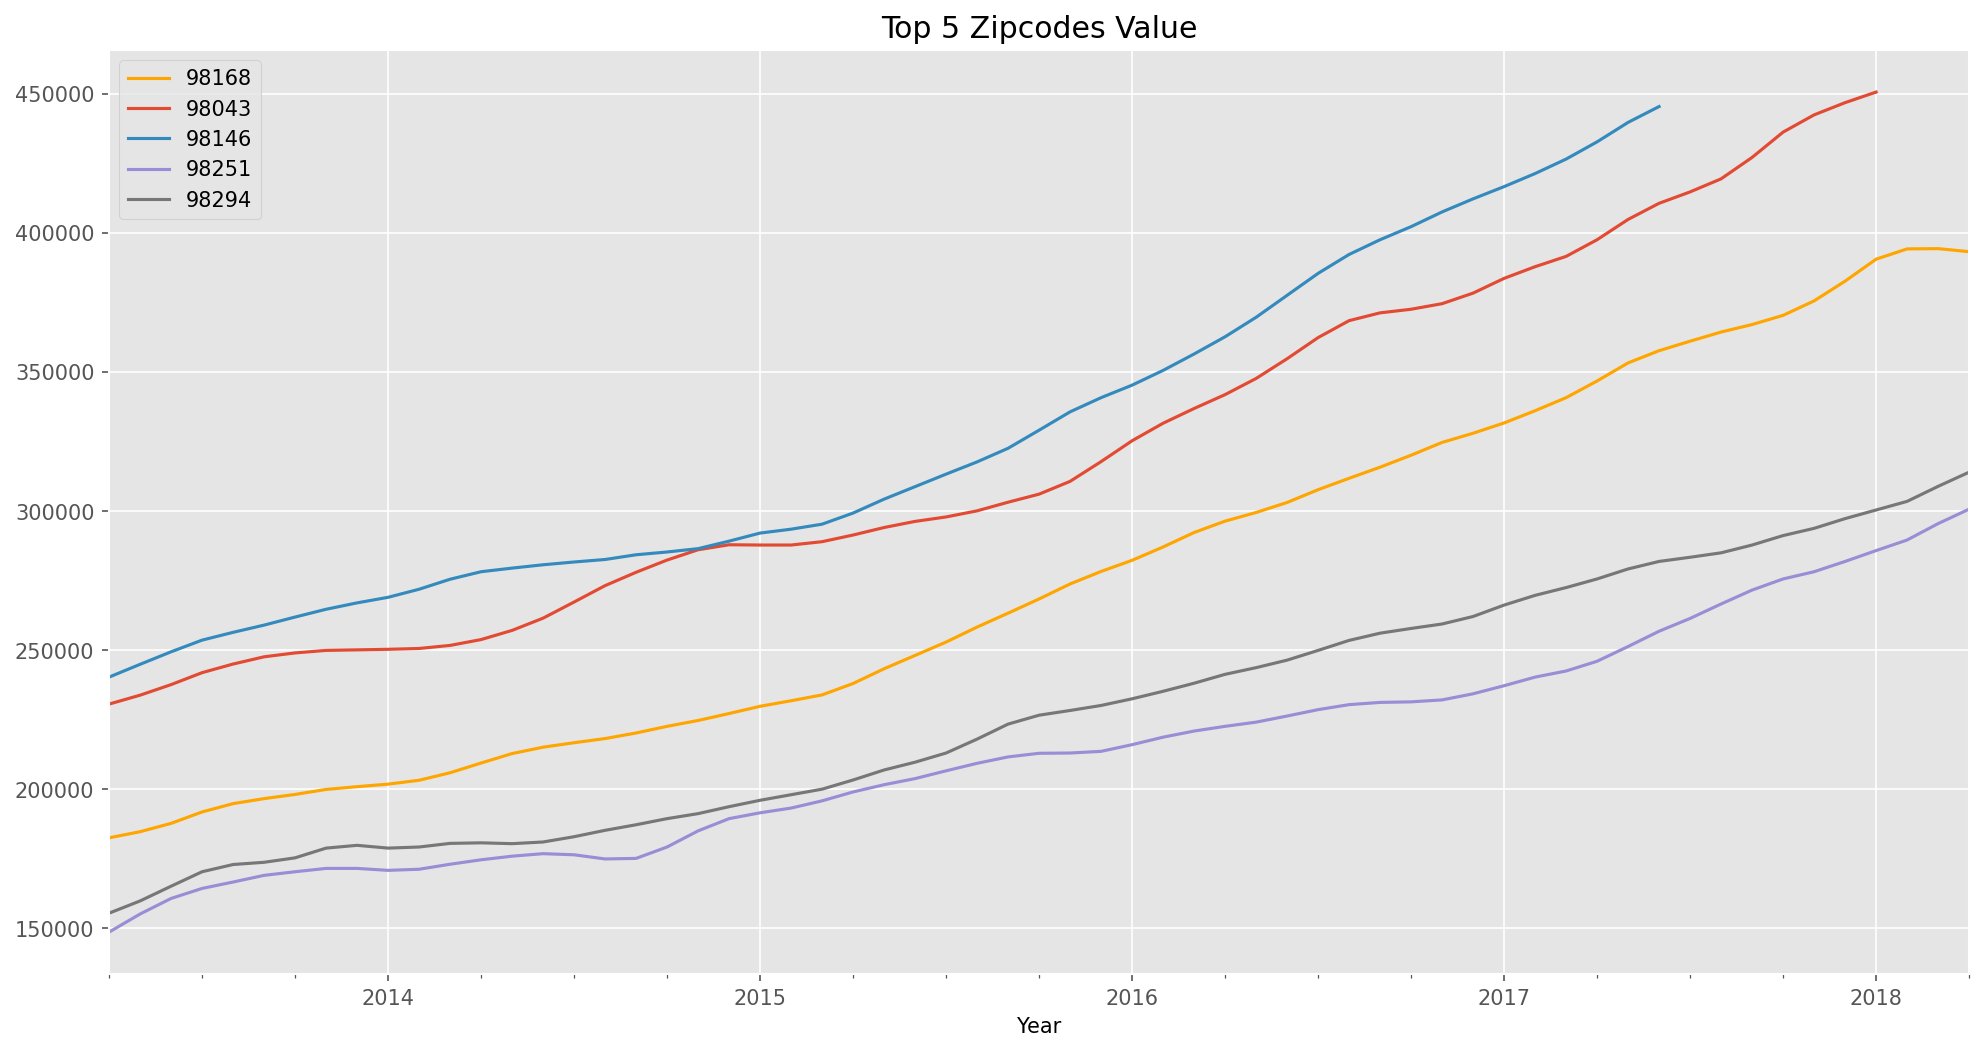

In [49]:
# code
# Visualizing The Value of the Top Five Zip Codes
  
# to set the plot size
plt.figure(figsize=(16, 8), dpi=150)
  
# using plot method to plot open prices.
# in plot method we set the label and color of the curve.
zip_98168['value'].plot(label='98168', color='orange')
zip_98043['value'].plot(label='98043')
zip_98146['value'].plot(label='98146')
zip_98251['value'].plot(label='98251')
zip_98294['value'].plot(label='98294')
  
# adding title to the plot
plt.title('Top 5 Zipcodes Value')
  
# adding Label to the x-axis
plt.xlabel('Year')
  
# adding legend to the curve
plt.legend()

#### zip_98168
Let's take a look at zipcode 98168. The p-value is 0.94 which is not less than our critical value of -2.91, meaning the series is not stationary. 

In [50]:
from statsmodels.tsa.stattools import adfuller

# Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test: \n')
dftest = adfuller(zip_98168['value'])

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test: 

Test Statistic                 -0.167287
p-value                         0.942310
#Lags Used                      6.000000
Number of Observations Used    54.000000
Critical Value (1%)            -3.557709
Critical Value (5%)            -2.916770
Critical Value (10%)           -2.596222
dtype: float64


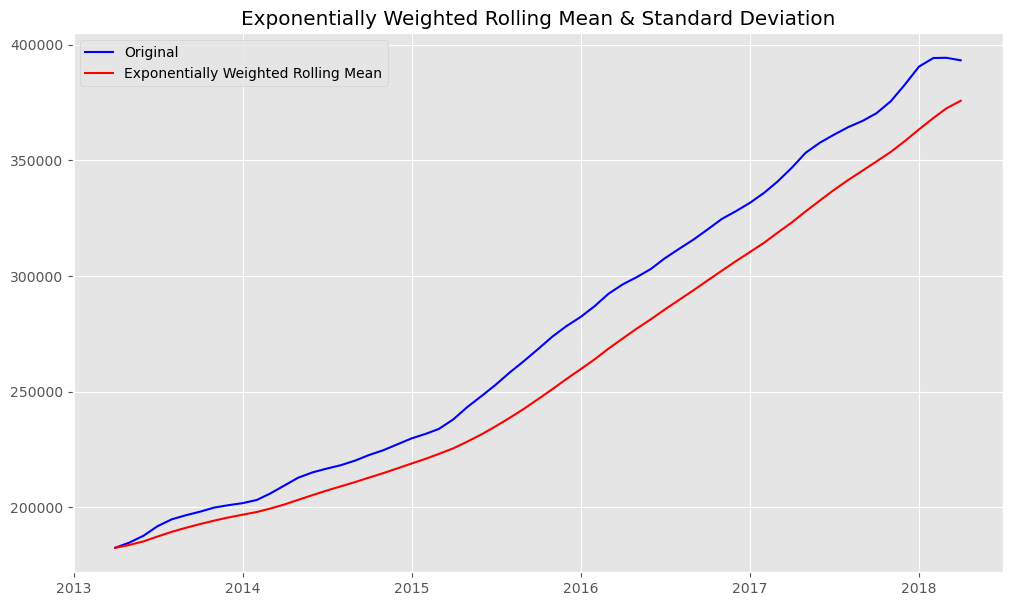

In [51]:
# Use Pandas ewm() to calculate Exponential Weighted Moving Average
exp_roll_mean = zip_98168.ewm(halflife=4).mean()

# Plot the original data with exp weighted average
fig = plt.figure(figsize=(12,7))
orig = plt.plot(zip_98168, color='blue',label='Original')
mean = plt.plot(exp_roll_mean, color='red', label='Exponentially Weighted Rolling Mean')
plt.legend(loc='best')
plt.title('Exponentially Weighted Rolling Mean & Standard Deviation')
plt.show(block=False)

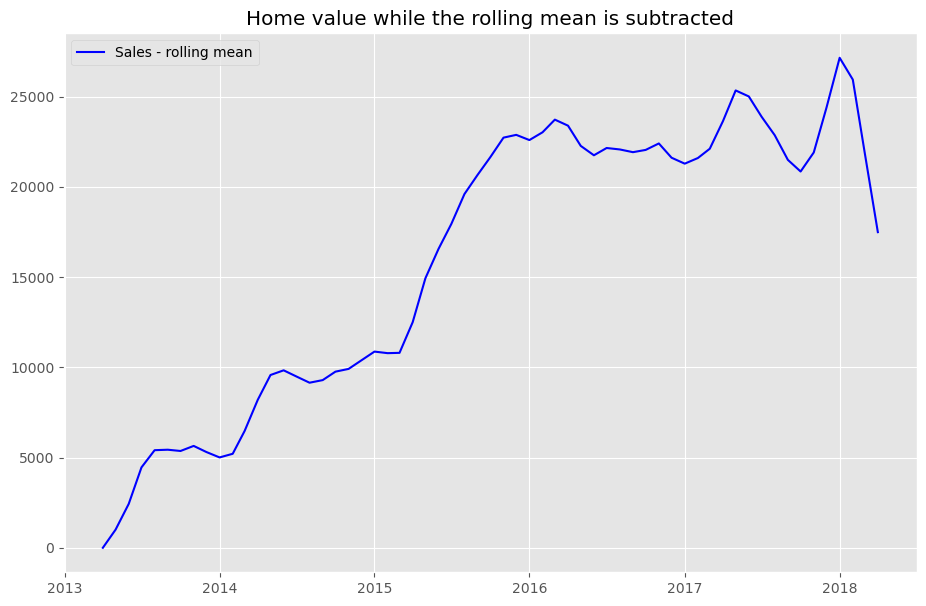

In [52]:
# Subtract the moving average from the original data
zip_98168_w = zip_98168 - exp_roll_mean

fig = plt.figure(figsize=(11,7))
plt.plot(zip_98168_w, color='blue',label='Sales - rolling mean')
plt.legend(loc='best')
plt.title('Home value while the rolling mean is subtracted')
plt.show(block=False)

#### zip_98043
Let's take a look at zipcode 98043. The p-value is 0.99 which is not less than our critical value of -2.93, meaning the series is not stationary. 

In [53]:
from statsmodels.tsa.stattools import adfuller

# Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test: \n')
dftest = adfuller(zip_98043['value'])

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test: 

Test Statistic                  1.665038
p-value                         0.998040
#Lags Used                      4.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64


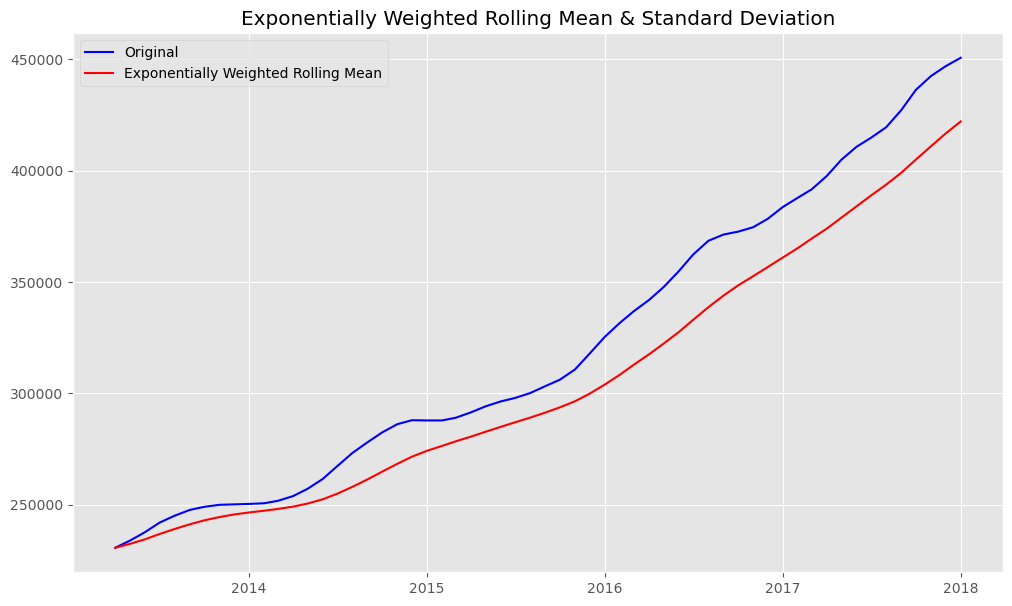

In [54]:
# Use Pandas ewm() to calculate Exponential Weighted Moving Average
exp_roll_mean = zip_98043.ewm(halflife=4).mean()

# Plot the original data with exp weighted average
fig = plt.figure(figsize=(12,7))
orig = plt.plot(zip_98043, color='blue',label='Original')
mean = plt.plot(exp_roll_mean, color='red', label='Exponentially Weighted Rolling Mean')
plt.legend(loc='best')
plt.title('Exponentially Weighted Rolling Mean & Standard Deviation')
plt.show(block=False)

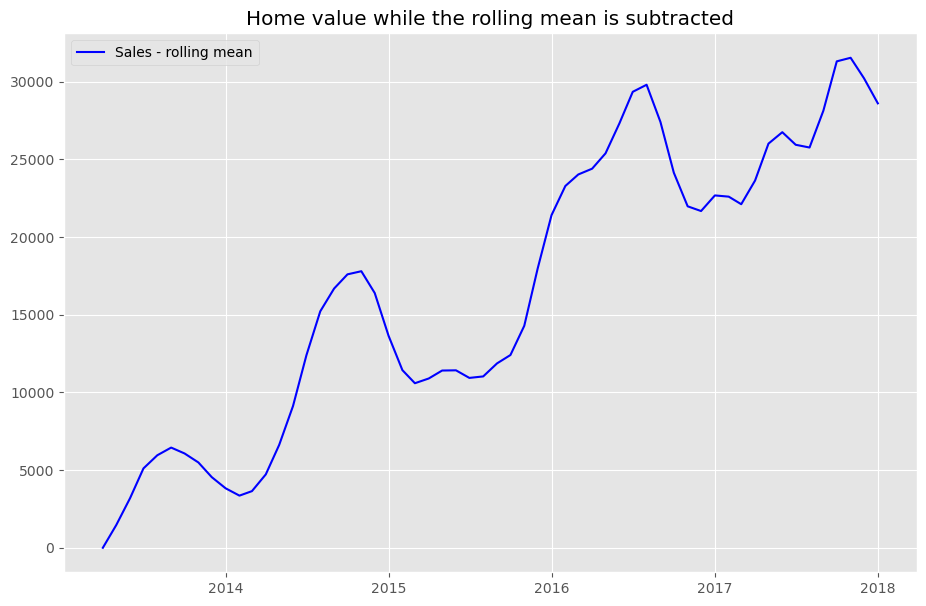

In [55]:
# Subtract the moving average from the original data
zip_98043_w = zip_98043 - exp_roll_mean

fig = plt.figure(figsize=(11,7))
plt.plot(zip_98043_w, color='blue',label='Sales - rolling mean')
plt.legend(loc='best')
plt.title('Home value while the rolling mean is subtracted')
plt.show(block=False)

#### zip_98146
Let's take a look at zipcode 98146. The p-value is 0.99 which is not less than our critical value of -2.95, meaning the series is not stationary. 

In [56]:
from statsmodels.tsa.stattools import adfuller

# Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test: \n')
dftest = adfuller(zip_98146['value'])

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test: 

Test Statistic                  1.426001
p-value                         0.997229
#Lags Used                     10.000000
Number of Observations Used    40.000000
Critical Value (1%)            -3.605565
Critical Value (5%)            -2.937069
Critical Value (10%)           -2.606986
dtype: float64


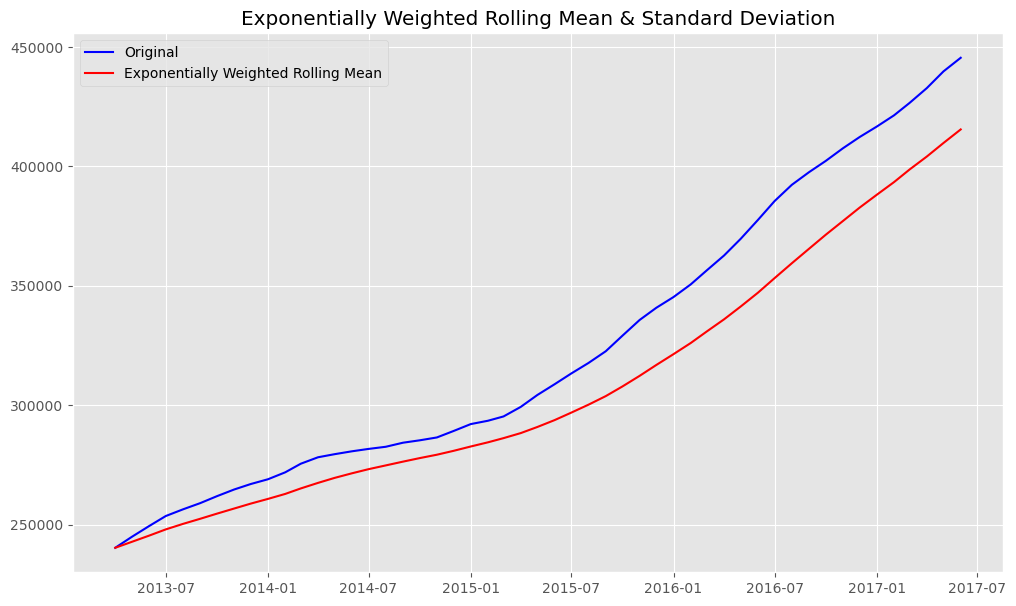

In [57]:
# Use Pandas ewm() to calculate Exponential Weighted Moving Average
exp_roll_mean = zip_98146.ewm(halflife=4).mean()

# Plot the original data with exp weighted average
fig = plt.figure(figsize=(12,7))
orig = plt.plot(zip_98146, color='blue',label='Original')
mean = plt.plot(exp_roll_mean, color='red', label='Exponentially Weighted Rolling Mean')
plt.legend(loc='best')
plt.title('Exponentially Weighted Rolling Mean & Standard Deviation')
plt.show(block=False)

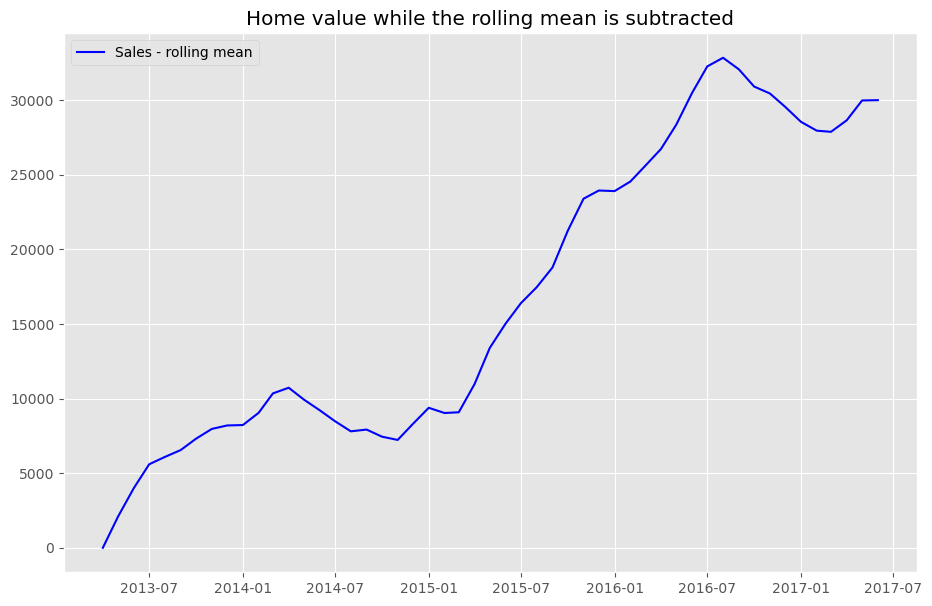

In [58]:
# Subtract the moving average from the original data
zip_98146_w = zip_98146 - exp_roll_mean

fig = plt.figure(figsize=(11,7))
plt.plot(zip_98146_w, color='blue',label='Sales - rolling mean')
plt.legend(loc='best')
plt.title('Home value while the rolling mean is subtracted')
plt.show(block=False)

#### zip_98251
Let's take a look at zipcode 98251. The p-value is 0.99 which is not less than our critical value of -2.91, meaning the series is not stationary. 

In [59]:
from statsmodels.tsa.stattools import adfuller

# Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test: \n')
dftest = adfuller(zip_98251['value'])

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test: 

Test Statistic                  2.293201
p-value                         0.998951
#Lags Used                      3.000000
Number of Observations Used    57.000000
Critical Value (1%)            -3.550670
Critical Value (5%)            -2.913766
Critical Value (10%)           -2.594624
dtype: float64


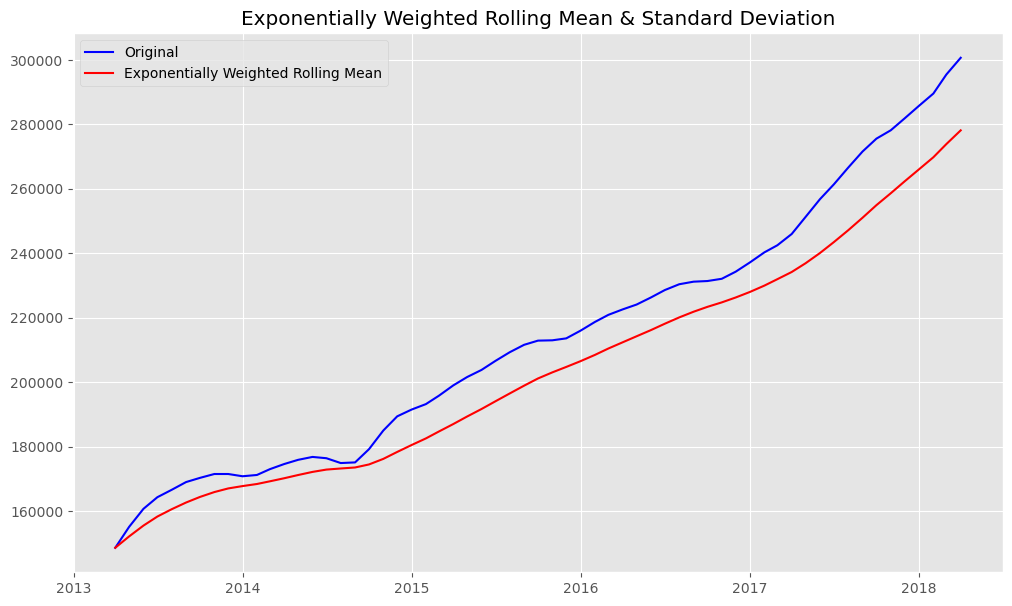

In [60]:
# Use Pandas ewm() to calculate Exponential Weighted Moving Average
exp_roll_mean = zip_98251.ewm(halflife=4).mean()

# Plot the original data with exp weighted average
fig = plt.figure(figsize=(12,7))
orig = plt.plot(zip_98251, color='blue',label='Original')
mean = plt.plot(exp_roll_mean, color='red', label='Exponentially Weighted Rolling Mean')
plt.legend(loc='best')
plt.title('Exponentially Weighted Rolling Mean & Standard Deviation')
plt.show(block=False)

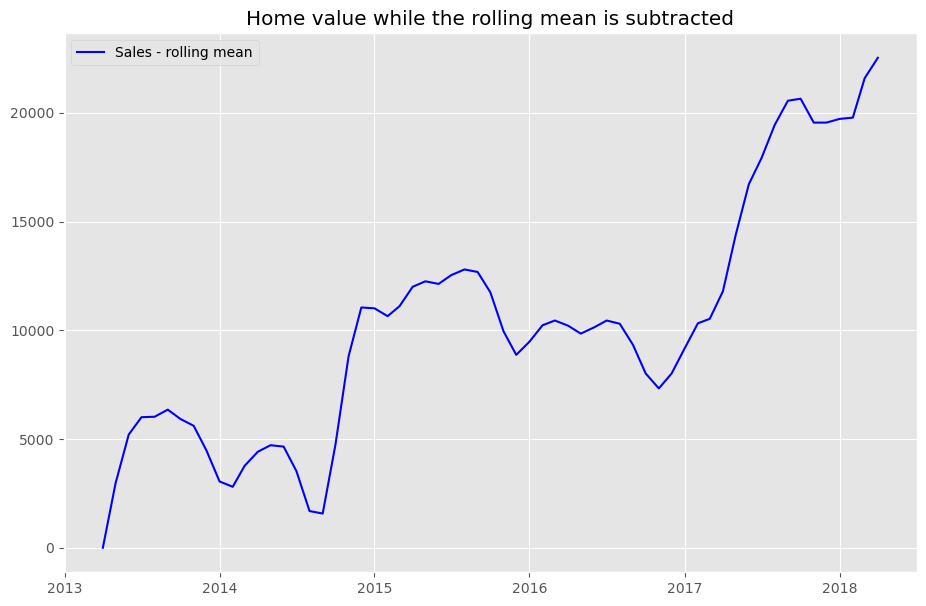

In [61]:
# Subtract the moving average from the original data
zip_98251_w = zip_98251 - exp_roll_mean

fig = plt.figure(figsize=(11,7))
plt.plot(zip_98251_w, color='blue',label='Sales - rolling mean')
plt.legend(loc='best')
plt.title('Home value while the rolling mean is subtracted')
plt.show(block=False)

#### zip_98294

Let's take a look at zipcode 98294. The p-value is 0.99 which is not less than our critical value of -2.91, meaning the series is not stationary. 

In [62]:
from statsmodels.tsa.stattools import adfuller

# Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test: \n')
dftest = adfuller(zip_98294['value'])

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test: 

Test Statistic                  2.674190
p-value                         0.999085
#Lags Used                      3.000000
Number of Observations Used    57.000000
Critical Value (1%)            -3.550670
Critical Value (5%)            -2.913766
Critical Value (10%)           -2.594624
dtype: float64


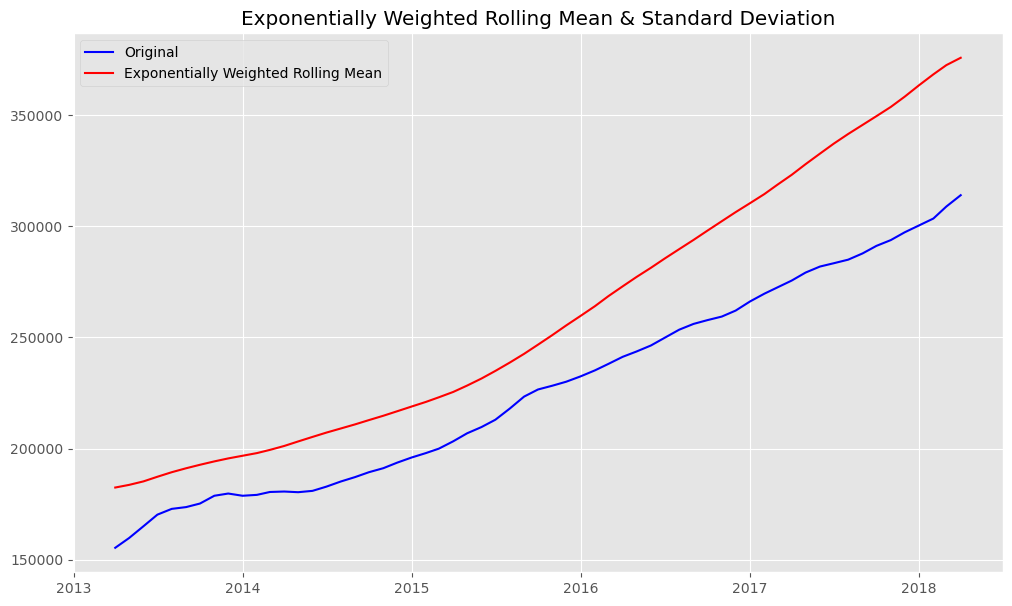

In [63]:
# Use Pandas ewm() to calculate Exponential Weighted Moving Average
exp_roll_mean = zip_98168.ewm(halflife=4).mean()

# Plot the original data with exp weighted average
fig = plt.figure(figsize=(12,7))
orig = plt.plot(zip_98294, color='blue',label='Original')
mean = plt.plot(exp_roll_mean, color='red', label='Exponentially Weighted Rolling Mean')
plt.legend(loc='best')
plt.title('Exponentially Weighted Rolling Mean & Standard Deviation')
plt.show(block=False)

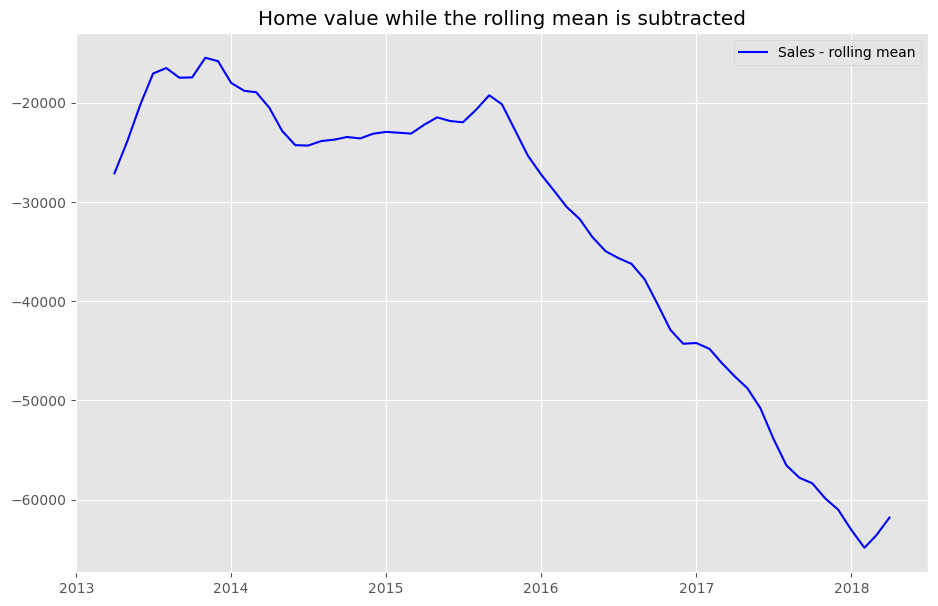

In [64]:
# Subtract the moving average from the original data
zip_98294_w = zip_98294 - exp_roll_mean

fig = plt.figure(figsize=(11,7))
plt.plot(zip_98294_w, color='blue',label='Sales - rolling mean')
plt.legend(loc='best')
plt.title('Home value while the rolling mean is subtracted')
plt.show(block=False)

### Weighted Zipcode Analysis 

In [65]:
zip_all_w = [zip_98168_w, zip_98043_w, zip_98146_w, zip_98251_w, zip_98294_w]
zip_names = ['98168', '98043', '98146', '98251', '98294']
zip_df_w = pd.concat(zip_all_w, axis = 1)
zip_df_w.columns = zip_names
zip_df_w.corr()

98168     98043     98146     98251     98294
98168  1.000000  0.870862  0.943169  0.710504 -0.698635
98043  0.870862  1.000000  0.883086  0.701583 -0.831554
98146  0.943169  0.883086  1.000000  0.610437 -0.805632
98251  0.710504  0.701583  0.610437  1.000000 -0.788708
98294 -0.698635 -0.831554 -0.805632 -0.788708  1.000000

In [66]:
# Perform backward filling of missing values
zip_df_w['98043'] = zip_df_w['98043'].ffill()
zip_df_w['98146'] = zip_df_w['98146'].ffill()
# Find the total number of missing values in the time series
zip_df_w.isna().sum()

98168    0
98043    0
98146    0
98251    0
98294    0
dtype: int64

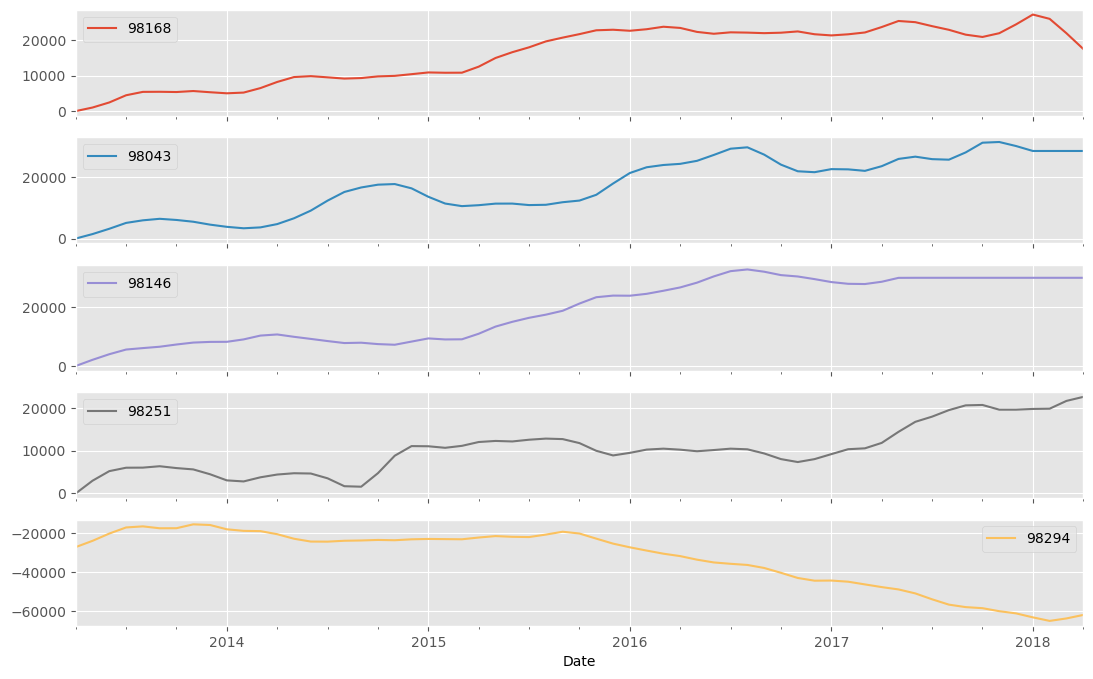

In [67]:
zip_df_w.plot(figsize=(13,8), subplots=True, legend=True);

#### ACF and PACF

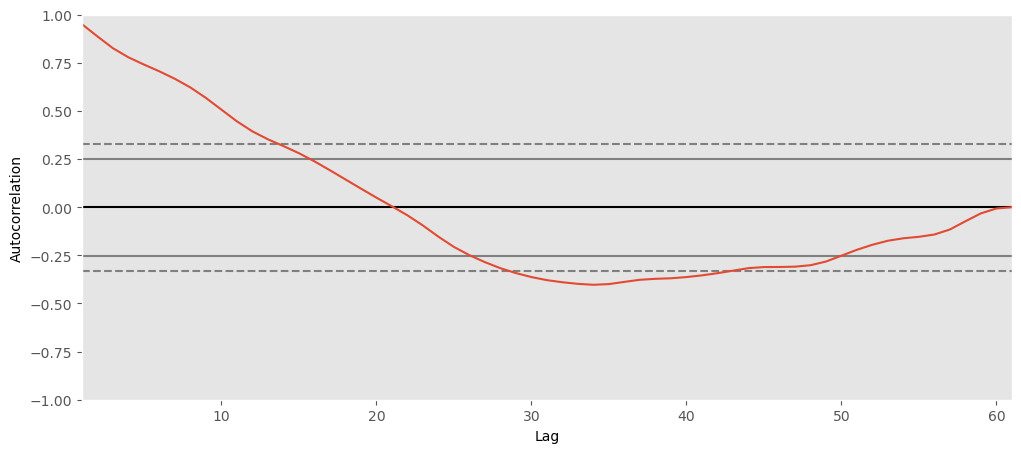

In [68]:
plt.figure(figsize=(12,5))
pd.plotting.autocorrelation_plot(zip_98168_w);
# Don't see spikes for yearly correlations

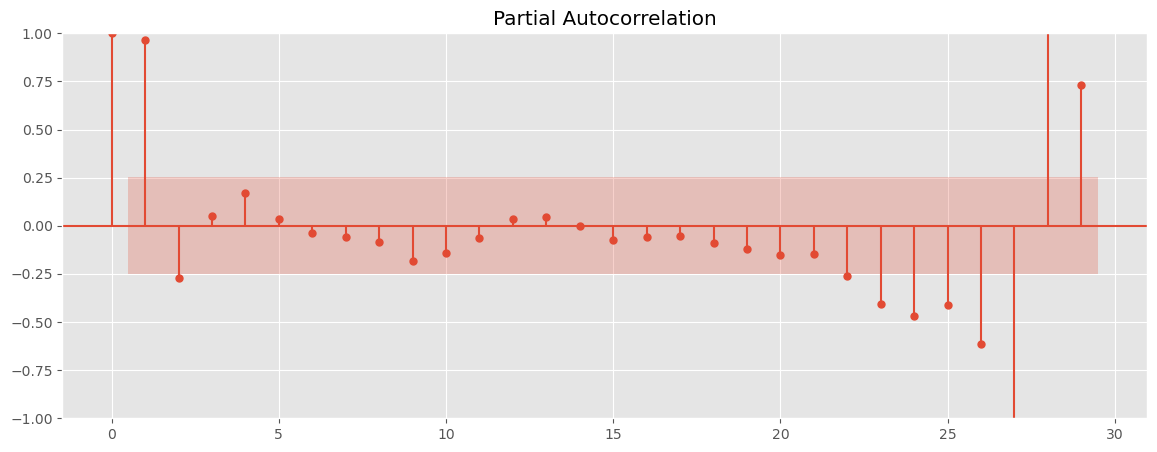

In [69]:
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 14, 5

plot_pacf(zip_98168_w, lags=29);

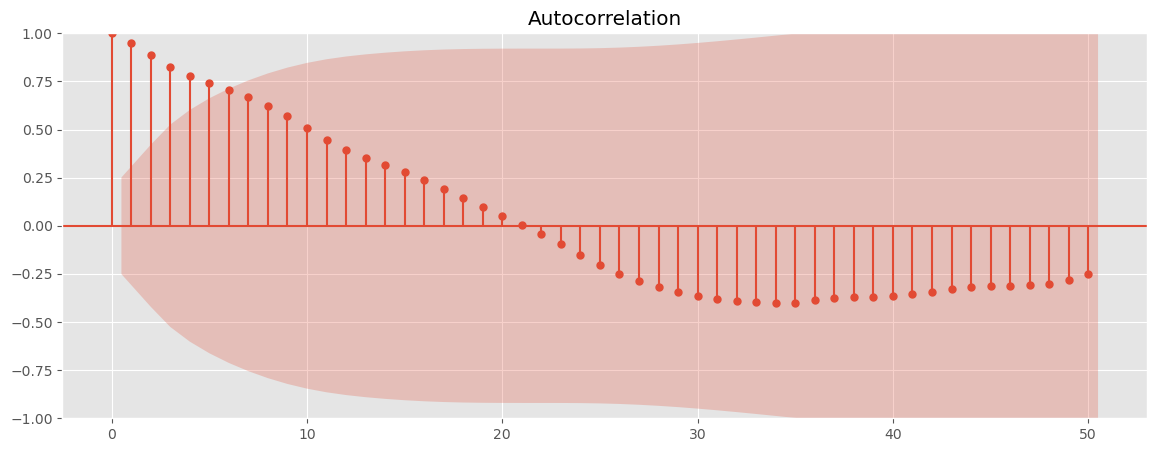

In [70]:
from statsmodels.graphics.tsaplots import plot_acf

rcParams['figure.figsize'] = 14, 5

plot_acf(zip_98168_w, lags=50);

### Train/Test Split

When doing a train/test split on timeseries you cannot randomly split the data seeing as its time sensitive. Hence, in this case we will make our training data from our first 4 years of data and our testing data from our last year of data. 

In [75]:
#Creating training data based on 2013-04-01 to 2017-04-01
zip_train = zip_df_w['2013-04-01': '2017-04-01']
train = zip_98168_w['2013-04-01': '2017-04-01']
zip_98043_train = zip_98043_w['2013-04-01': '2017-04-01']
zip_98146_train = zip_98146_w['2013-04-01': '2017-04-01']
zip_98251_train = zip_98251_w['2013-04-01': '2017-04-01']
zip_98294_train = zip_98294_w['2013-04-01': '2017-04-01']

#Creating test data based on the last year of our
zip_test = zip_df_w['2017-04-01':]
valid = zip_98168_w['2017-04-01':]
zip_98043_test = zip_98168_w['2017-04-01':]
zip_98146_test = zip_98168_w['2017-04-01':]
zip_98251_test = zip_98168_w['2017-04-01':]
zip_98294_test = zip_98168_w['2017-04-01':]

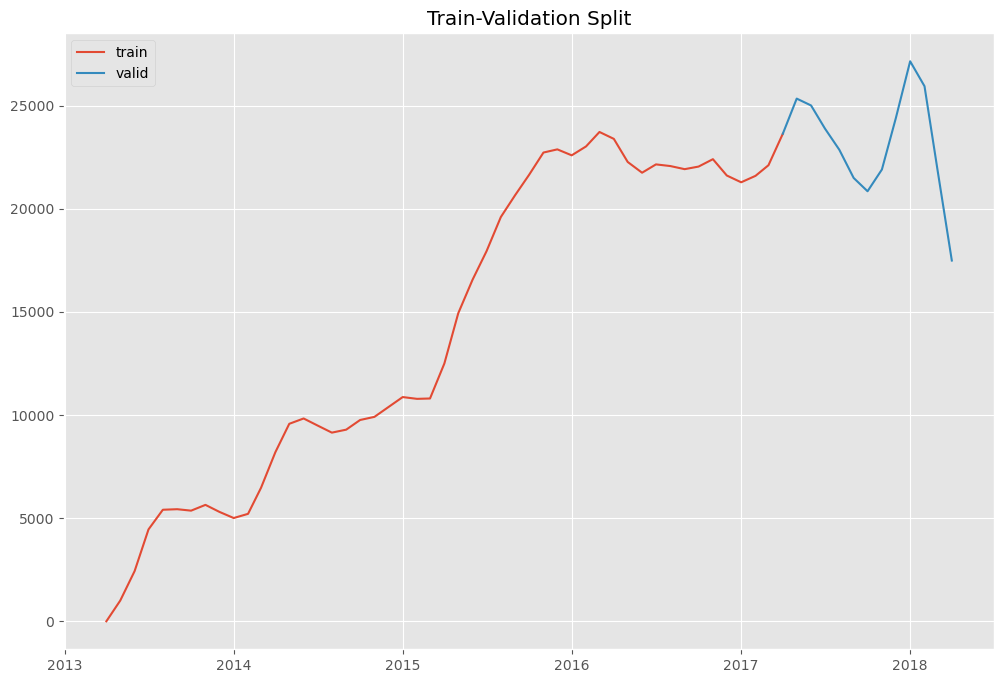

In [76]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(train, label='train')
# ax.plot(valid)
ax.plot(valid, label='valid')
ax.set_title('Train-Validation Split');
plt.legend()

### Baseline

In [77]:
train

value
Date                    
2013-04-01      0.000000
2013-05-01   1004.930043
2013-06-01   2433.138434
2013-07-01   4454.246945
2013-08-01   5407.842420
2013-09-01   5433.846624
2013-10-01   5363.898358
2013-11-01   5644.162479
2013-12-01   5305.668770
2014-01-01   5006.305072
2014-02-01   5209.068722
2014-03-01   6470.941653
2014-04-01   8198.191708
2014-05-01   9573.959270
2014-06-01   9833.080568
2014-07-01   9492.766858
2014-08-01   9146.759431
2014-09-01   9291.268142
2014-10-01   9759.350138
2014-11-01   9911.618402
2014-12-01  10383.592942
2015-01-01  10871.178558
2015-02-01  10784.555615
2015-03-01  10802.037280
2015-04-01  12499.502813
2015-05-01  14935.899462
2015-06-01  16566.400305
2015-07-01  17940.161936
2015-08-01  19602.101302
2015-09-01  20666.075115
2015-10-01  21647.467867
2015-11-01  22727.242892
2015-12-01  22881.014665
2016-01-01  22592.302866
2016-02-01  23023.943026
2016-03-01  23724.624784
2016-04-01  23390.344482
2016-05-01  22269.806865
2016-06-01  21749.042267
2016-07-01  22152.717214
2016-08-01  22072.382956
2016-09-01  21921.306906
2016-10-01  22046.979084
2016-11-01  22405.278046
2016-12-01  21613.796224
2017-01-01  21284.889453
2017-02-01  21597.144657
2017-03-01  22112.152947
2017-04-01  23638.490209

In [78]:
# we can perform this with the shift operator
# The prediction for the next day is the original series shifted to the future by one day.
naive = train.shift(1)
naive

value
Date                    
2013-04-01           NaN
2013-05-01      0.000000
2013-06-01   1004.930043
2013-07-01   2433.138434
2013-08-01   4454.246945
2013-09-01   5407.842420
2013-10-01   5433.846624
2013-11-01   5363.898358
2013-12-01   5644.162479
2014-01-01   5305.668770
2014-02-01   5006.305072
2014-03-01   5209.068722
2014-04-01   6470.941653
2014-05-01   8198.191708
2014-06-01   9573.959270
2014-07-01   9833.080568
2014-08-01   9492.766858
2014-09-01   9146.759431
2014-10-01   9291.268142
2014-11-01   9759.350138
2014-12-01   9911.618402
2015-01-01  10383.592942
2015-02-01  10871.178558
2015-03-01  10784.555615
2015-04-01  10802.037280
2015-05-01  12499.502813
2015-06-01  14935.899462
2015-07-01  16566.400305
2015-08-01  17940.161936
2015-09-01  19602.101302
2015-10-01  20666.075115
2015-11-01  21647.467867
2015-12-01  22727.242892
2016-01-01  22881.014665
2016-02-01  22592.302866
2016-03-01  23023.943026
2016-04-01  23724.624784
2016-05-01  23390.344482
2016-06-01  22269.806865
2016-07-01  21749.042267
2016-08-01  22152.717214
2016-09-01  22072.382956
2016-10-01  21921.306906
2016-11-01  22046.979084
2016-12-01  22405.278046
2017-01-01  21613.796224
2017-02-01  21284.889453
2017-03-01  21597.144657
2017-04-01  22112.152947

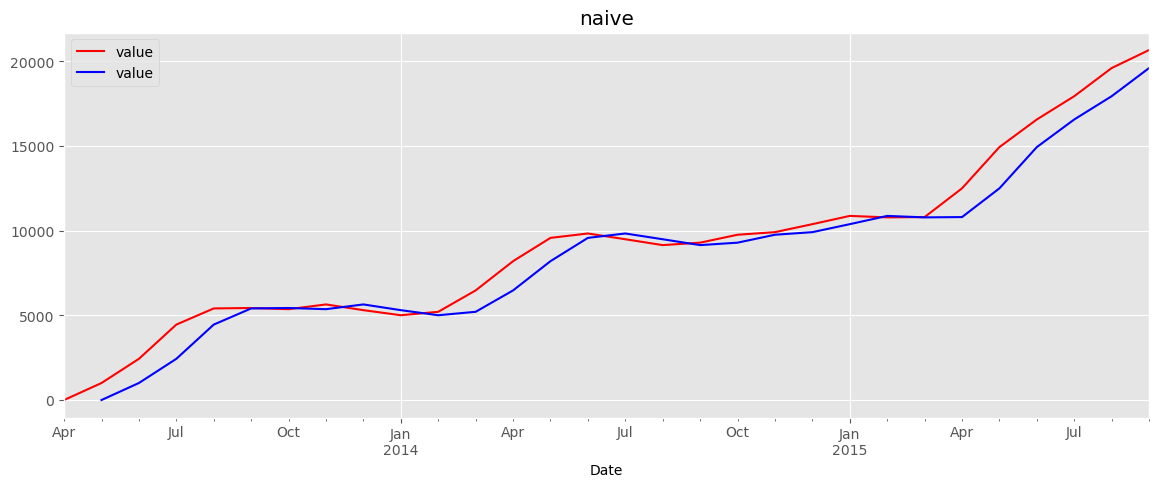

In [79]:
fig, ax = plt.subplots()

train[0:30].plot(ax=ax, c='r', label='original')
naive[0:30].plot(ax=ax, c='b', label='shifted')
ax.set_title('naive')
ax.legend();

In [81]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(train[1:], naive.dropna()))

929.2526527669714

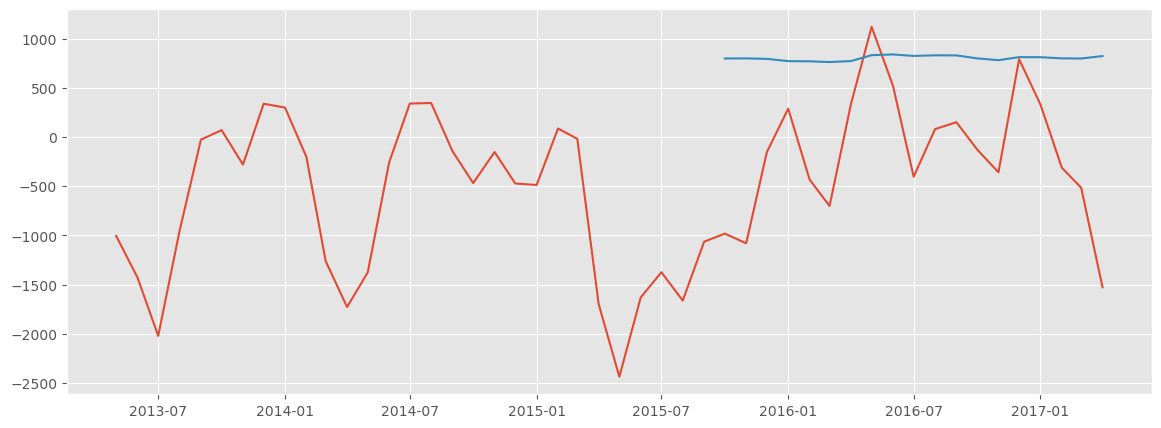

In [82]:
fig, ax = plt.subplots()
residuals = naive[1:] - train[1:]
ax.plot(residuals.index, residuals)
ax.plot(residuals.index, residuals.rolling(30).std());

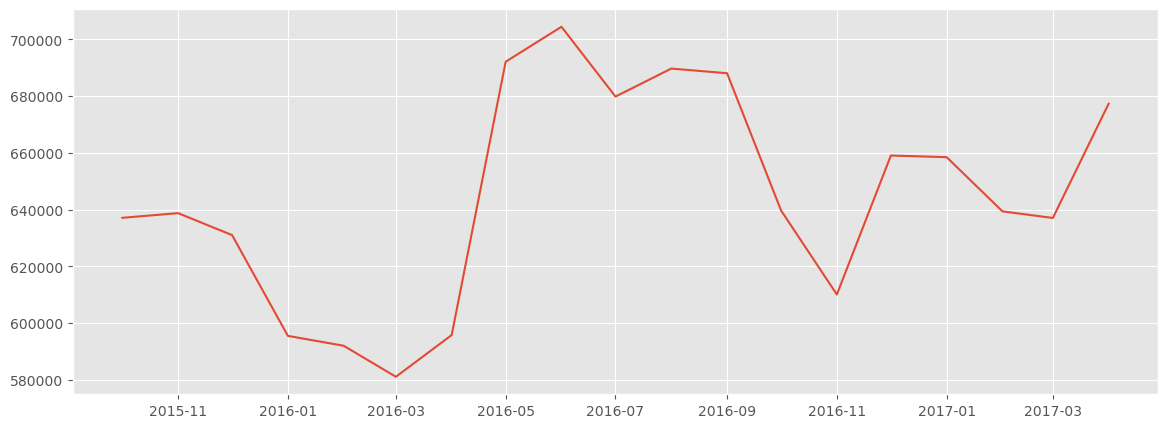

In [83]:
fig, ax = plt.subplots()

ax.plot(residuals.index, residuals.rolling(30).var());

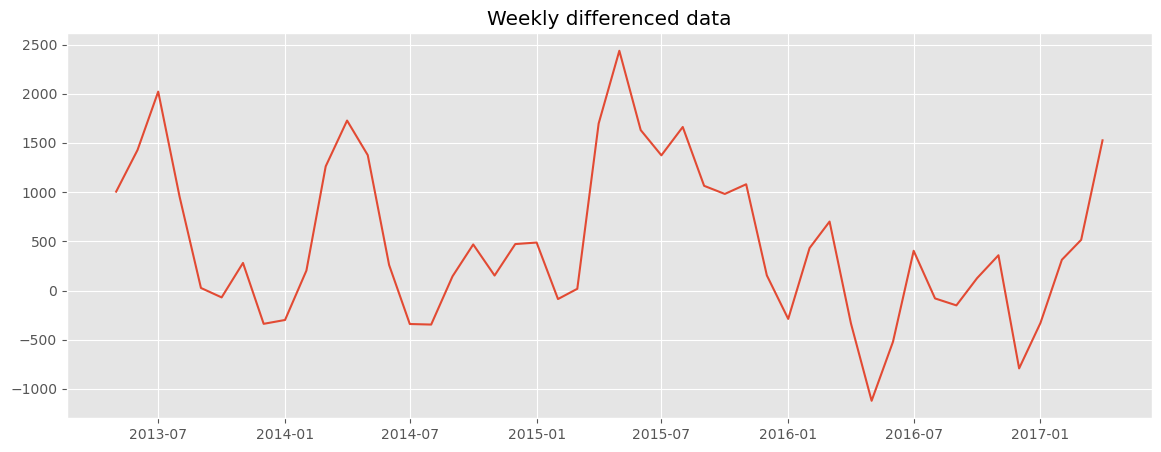

In [84]:
fig, ax = plt.subplots()
ax.plot(train.diff())
ax.set_title('Weekly differenced data');

In [85]:
ar_1 = ARIMA(train, order=(1, 1, 0)).fit()

# We put a typ='levels' to convert our predictions to remove the differencing performed.
ar_1.predict(typ='levels')

2013-04-01        0.000000
2013-05-01        0.000000
2013-06-01     1778.453335
2013-07-01     3532.471133
2013-08-01     6009.951762
2013-09-01     6141.852032
2013-10-01     5453.862801
2013-11-01     5310.057184
2013-12-01     5859.889759
2014-01-01     5045.120517
2014-02-01     4775.876303
2014-03-01     5365.141681
2014-04-01     7442.241207
2014-05-01     9527.705298
2014-06-01    10632.926769
2014-07-01    10032.533616
2014-08-01     9230.817698
2014-09-01     8880.427653
2014-10-01     9402.500616
2014-11-01    10119.646190
2014-12-01    10028.823623
2015-01-01    10746.885196
2015-02-01    11246.487101
2015-03-01    10717.879467
2015-04-01    10815.493415
2015-05-01    13806.090406
2015-06-01    16811.263394
2015-07-01    17821.443269
2015-08-01    18997.585412
2015-09-01    20881.343393
2015-10-01    21485.046078
2015-11-01    22402.873835
2015-12-01    23558.376500
2016-01-01    22999.377181
2016-02-01    22370.073166
2016-03-01    23356.188758
2016-04-01    24263.959501
2

In [86]:
ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   49
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -376.604
Date:                Mon, 10 Apr 2023   AIC                            757.208
Time:                        12:35:14   BIC                            760.951
Sample:                    04-01-2013   HQIC                           758.623
                         - 04-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7697      0.105      7.324      0.000       0.564       0.976
sigma2       3.77e+05   8.32e+04      4.531      0.000    2.14e+05     5.4e+05
===================================================================================
Ljung-Box (L1) (Q):                   2.55   Jarque-Bera (JB):                 0.31
Prob(Q):                              0.11   Prob(JB):                         0.86
Heteroskedasticity (H):               1.02   Skew:                             0.11
Prob(H) (two-sided):                  0.97   Kurtosis:                         2.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [87]:
ar_1.aic

757.2084726074023

In [88]:
random_walk_model = ARIMA(train, order=(0, 1, 0)).fit()
random_walk_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   49
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -396.159
Date:                Mon, 10 Apr 2023   AIC                            794.319
Time:                        12:35:35   BIC                            796.190
Sample:                    04-01-2013   HQIC                           795.026
                         - 04-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      8.631e+05   1.72e+05      5.030      0.000    5.27e+05     1.2e+06
===================================================================================
Ljung-Box (L1) (Q):                  21.36   Jarque-Bera (JB):                 1.90
Prob(Q):                              0.00   Prob(JB):                         0.39
Heteroskedasticity (H):               0.41   Skew:                             0.41
Prob(H) (two-sided):                  0.08   Kurtosis:                         2.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [89]:
print(f'Random Walk AIC: {random_walk_model.aic}')
print(f'AR(1, 1, 0) AIC: {ar_1.aic}' )

Random Walk AIC: 794.3186481413701
AR(1, 1, 0) AIC: 757.2084726074023


In [90]:
y_hat_ar1 = ar_1.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_ar1))

615.6322101074502

In [91]:
y_hat_rw = random_walk_model.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_rw))

919.7216043774596

In [92]:
ar_1.arparams

array([0.7697285])

In [94]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(np.array(train.diff().shift(1).dropna()).reshape(-1,1), train[1:].diff().dropna())
print(lr.coef_)

[[0.67098052]]


In [95]:
ar_2 = ARIMA(train, order=(2, 1, 0)).fit()

ar_2.predict(typ='levels')

2013-04-01        0.000000
2013-05-01        0.000000
2013-06-01     1844.953816
2013-07-01     3552.066366
2013-08-01     6035.545113
2013-09-01     5681.744475
2013-10-01     5126.418113
2013-11-01     5282.733862
2013-12-01     5957.365399
2014-01-01     4858.775054
2014-02-01     4816.578475
2014-03-01     5522.846933
2014-04-01     7699.676549
2014-05-01     9535.096297
2014-06-01    10385.712929
2014-07-01     9617.813542
2014-08-01     9051.408535
2014-09-01     8909.625076
2014-10-01     9561.388139
2014-11-01    10190.853423
2014-12-01     9904.410693
2015-01-01    10816.386211
2015-02-01    11208.002068
2015-03-01    10524.441123
2015-04-01    10850.403804
2015-05-01    14241.859517
2015-06-01    16850.598728
2015-07-01    17392.003055
2015-08-01    18783.757851
2015-09-01    20832.517725
2015-10-01    21179.553882
2015-11-01    22285.457364
2015-12-01    23495.514436
2016-01-01    22660.970673
2016-02-01    22241.020068
2016-03-01    23569.743480
2016-04-01    24295.085454
2

In [96]:
print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)

794.3186481413701
757.2084726074023
753.5358036571281


In [97]:
y_hat_ar1 = ar_2.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_ar1))

581.5629693115693

### Moving Average Model (MA)

In [99]:
ma_1 = ARIMA(train, order=(0, 0, 1)).fit()
y_hat = ma_1.predict(typ='levels')
y_hat

2013-04-01    14212.318212
2013-05-01     7106.159119
2013-06-01    10144.832174
2013-07-01     8428.547933
2013-08-01    11032.877440
2013-09-01     9524.789061
2013-10-01    10705.796152
2013-11-01     9538.157686
2013-12-01    10750.989176
2014-01-01     9311.529905
2014-02-01    10298.477506
2014-03-01     9547.026893
2014-04-01    11372.854957
2014-05-01    11264.416673
2014-06-01    12634.557998
2014-07-01    11585.933172
2014-08-01    12242.279369
2014-09-01    11288.771667
2014-10-01    12319.946495
2014-11-01    11779.751732
2014-12-01    12433.143657
2015-01-01    12255.928945
2015-02-01    12887.774401
2015-03-01    12196.733601
2015-04-01    12873.409784
2015-05-01    13852.792290
2015-06-01    15255.310271
2015-07-01    15476.583560
2015-08-01    16590.945527
2015-09-01    17123.102023
2015-10-01    17641.001721
2015-11-01    18093.582141
2015-12-01    18705.564822
2016-01-01    18264.960540
2016-02-01    18416.022007
2016-03-01    18692.241230
2016-04-01    19108.691180
2

In [100]:
ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   49
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -476.849
Date:                Mon, 10 Apr 2023   AIC                            959.697
Time:                        12:38:55   BIC                            965.373
Sample:                    04-01-2013   HQIC                           961.850
                         - 04-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.421e+04   1161.266     12.239      0.000    1.19e+04    1.65e+04
ma.L1          0.9999      0.322      3.107      0.002       0.369       1.631
sigma2      1.548e+07      0.000   1.09e+11      0.000    1.55e+07    1.55e+07
===================================================================================
Ljung-Box (L1) (Q):                  39.11   Jarque-Bera (JB):                 3.04
Prob(Q):                              0.00   Prob(JB):                         0.22
Heteroskedasticity (H):               0.75   Skew:                            -0.35
Prob(H) (two-sided):                  0.58   Kurtosis:                         2.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.1e+29. Standard errors may be unstable.
"""

In [101]:
ma_1 = ARIMA(train, order=(0, 1, 1)).fit()

print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)

794.3186481413701
757.2084726074023
753.5358036571281
758.5849215680709


In [102]:
y_hat_ar1 = ma_1.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_ar1))

627.0444091271057

In [103]:
ma_2 = ARIMA(train, order=(0, 1, 2)).fit()
y_hat = ma_2.predict(typ='levels')
y_hat

2013-04-01        0.000000
2013-05-01        0.000000
2013-06-01     1816.674232
2013-07-01     3385.293514
2013-08-01     6066.882118
2013-09-01     5160.911987
2013-10-01     5367.498588
2013-11-01     5538.782339
2013-12-01     5781.336147
2014-01-01     4738.339866
2014-02-01     5042.497596
2014-03-01     5619.314861
2014-04-01     7735.323991
2014-05-01     9416.118460
2014-06-01    10110.335491
2014-07-01     9567.811532
2014-08-01     9196.721258
2014-09-01     9026.416823
2014-10-01     9615.218477
2014-11-01    10140.639698
2014-12-01     9702.235267
2015-01-01    11146.743384
2015-02-01    10976.109080
2015-03-01    10331.188549
2015-04-01    11306.075660
2015-05-01    14448.992814
2015-06-01    16434.846544
2015-07-01    17086.953912
2015-08-01    19189.839997
2015-09-01    20760.784742
2015-10-01    20827.296586
2015-11-01    22693.366787
2015-12-01    23349.505853
2016-01-01    22269.374030
2016-02-01    22701.114463
2016-03-01    23688.732541
2016-04-01    24000.153248
2

In [104]:
print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)
print(ma_2.aic)

794.3186481413701
757.2084726074023
753.5358036571281
758.5849215680709
744.9216004655689


In [105]:
y_hat_ar1 = ma_2.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_ar1))

536.6108203779672

### ARMA

In [107]:
arma_21 = ARIMA(train, order=(2, 1, 2)).fit()

In [108]:
print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)
print(ma_2.aic)
print(arma_21.aic)

794.3186481413701
757.2084726074023
753.5358036571281
758.5849215680709
744.9216004655689
747.2676628338363


In [109]:
def find_rmse(model, train_data=train):
    y_hat = model.predict(typ='levels')
    return np.sqrt(mean_squared_error(train_data, y_hat))

In [110]:
print(find_rmse(random_walk_model))
print(find_rmse(ar_1))
print(find_rmse(ar_2))
print(find_rmse(ma_1))
print(find_rmse(ma_2))
print(find_rmse(arma_21))

919.7216043774596
615.6322101074502
581.5629693115693
627.0444091271057
536.6108203779672
524.4223884688748


In [111]:
def find_rmse_test(model, test_data=valid):
    y_hat = model.predict(start=test_data.index[0], end=test_data.index[-1], typ='levels')
    return np.sqrt(mean_squared_error(test_data, y_hat))

In [112]:
print(find_rmse_test(random_walk_model))
print(find_rmse_test(ar_1))
print(find_rmse_test(ar_2))
print(find_rmse_test(ma_1))
print(find_rmse_test(ma_2))
print(find_rmse_test(arma_21))

2514.5789594525
5022.856202278511
3915.3342883981704
2735.4550389183873
4198.432457829097
5284.887140577332
